# Acquire

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal


from env import user, password, host
import acquire
import prepare
import explore

In [2]:
def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url('zillow')

In [4]:
acquire_df = pd.read_sql('''
SELECT  propertylandusetypeid
        roomcnt,
        bedroomcnt,
        bathroomcnt,
        fullbathcnt
        garagecarcnt,
        garagetotalsqft,
        yearbuilt,
        taxamount,
        fips,
        calculatedfinishedsquarefeet,
        taxvaluedollarcnt,
        lotsizesquarefeet,
        landtaxvaluedollarcnt,
        poolcnt
FROM properties_2017 
JOIN propertylandusetype USING (propertylandusetypeid)
JOIN predictions_2017 ON properties_2017.id = predictions_2017.id
WHERE propertylandusetype.propertylandusedesc = "Single Family Residential" 
AND predictions_2017.transactiondate LIKE "2017%%"
''', url)

In [5]:
acquire_df.head()

,roomcnt,bedroomcnt,bathroomcnt,garagecarcnt,garagetotalsqft,yearbuilt,taxamount,fips,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,landtaxvaluedollarcnt,poolcnt
0,261.0,3.0,3.0,3.0,NaN,1936.0,7262.79,6037.0,2490.0,594518.0,6729.0,399435.0,NaN
1,261.0,2.0,2.0,2.0,NaN,1938.0,11864.30,6037.0,1600.0,980000.0,10080.0,784000.0,NaN
2,261.0,2.0,2.0,2.0,NaN,1954.0,3888.13,6037.0,1276.0,322119.0,5750.0,142807.0,1.0
3,261.0,3.0,2.0,2.0,NaN,1937.0,5268.54,6037.0,1976.0,435017.0,6235.0,202513.0,1.0
4,261.0,4.0,3.0,3.0,NaN,1946.0,7925.72,6037.0,1998.0,658823.0,5066.0,403546.0,NaN


# Clean/Prep

In [6]:
acquire_df.shape

(56079, 13)

In [7]:
acquire_df.describe().T

,count,mean,std,min,25%,50%,75%,max
roomcnt,56079.0,261.000000,0.000000,261.0,261.00,261.00,261.00,261.00
bedroomcnt,56079.0,3.289110,0.958756,0.0,3.00,3.00,4.00,25.00
bathroomcnt,56079.0,2.239457,1.007012,0.0,2.00,2.00,3.00,20.00
garagecarcnt,55693.0,2.199289,0.973534,1.0,2.00,2.00,3.00,20.00
garagetotalsqft,18247.0,488.088343,162.185770,0.0,420.00,460.00,532.00,3774.00
yearbuilt,55830.0,1961.186262,21.995171,1862.0,1949.00,1958.00,1976.00,2016.00
taxamount,55949.0,5589.363490,8541.810318,8.3,2523.76,4130.48,6410.56,1195295.62
fips,56079.0,6048.841581,21.237610,6037.0,6037.00,6037.00,6059.00,6111.00
calculatedfinishedsquarefeet,55848.0,1868.285704,966.973076,20.0,1260.00,1630.00,2217.00,26345.00
taxvaluedollarcnt,56071.0,457643.446951,663558.094993,9.0,187026.00,329525.00,533484.50,67506489.00


In [8]:
acquire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   roomcnt                       56079 non-null  float64
 1   bedroomcnt                    56079 non-null  float64
 2   bathroomcnt                   56079 non-null  float64
 3   garagecarcnt                  55693 non-null  float64
 4   garagetotalsqft               18247 non-null  float64
 5   yearbuilt                     55830 non-null  float64
 6   taxamount                     55949 non-null  float64
 7   fips                          56079 non-null  float64
 8   calculatedfinishedsquarefeet  55848 non-null  float64
 9   taxvaluedollarcnt             56071 non-null  float64
 10  lotsizesquarefeet             55729 non-null  float64
 11  landtaxvaluedollarcnt         56071 non-null  float64
 12  poolcnt                       10951 non-null  float64
dtypes

In [9]:
# How many nulls are present in our dataset?
acquire_df.isnull().sum()

roomcnt                             0
bedroomcnt                          0
bathroomcnt                         0
garagecarcnt                      386
garagetotalsqft                 37832
yearbuilt                         249
taxamount                         130
fips                                0
calculatedfinishedsquarefeet      231
taxvaluedollarcnt                   8
lotsizesquarefeet                 350
landtaxvaluedollarcnt               8
poolcnt                         45128
dtype: int64

In [10]:
acquire_df.garagecarcnt.value_counts().sum()

55693

In [11]:
acquire_df['garagecarcnt'].value_counts()

2.0     28258
3.0     11896
1.0     11417
4.0      2648
5.0       938
6.0       330
7.0       126
8.0        40
9.0        25
10.0        9
11.0        3
13.0        1
20.0        1
19.0        1
Name: garagecarcnt, dtype: int64

In [12]:
acquire_df.garagecarcnt

0        3.0
1        2.0
2        2.0
3        2.0
4        3.0
        ... 
56074    1.0
56075    2.0
56076    1.0
56077    2.0
56078    2.0
Name: garagecarcnt, Length: 56079, dtype: float64

In [13]:
# What's the percentage of nulls?
acquire_df.isna().mean()

roomcnt                         0.000000
bedroomcnt                      0.000000
bathroomcnt                     0.000000
garagecarcnt                    0.006883
garagetotalsqft                 0.674620
yearbuilt                       0.004440
taxamount                       0.002318
fips                            0.000000
calculatedfinishedsquarefeet    0.004119
taxvaluedollarcnt               0.000143
lotsizesquarefeet               0.006241
landtaxvaluedollarcnt           0.000143
poolcnt                         0.804722
dtype: float64

**Takeaways**
- `poolcnt` has far too many nulls to be used moving forward (drop)
- Because `garagetotalsqft` is composed of 67% null values, I'll drop this variable as well (drop)
- `roomcnt`, `garagecarcnt`, `lotsizesquarefeet`,  all have limited nulls, so I'll move forward

In [14]:
acquire_df.drop(columns=['garagetotalsqft','poolcnt'])

,roomcnt,bedroomcnt,bathroomcnt,garagecarcnt,yearbuilt,taxamount,fips,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,landtaxvaluedollarcnt
0,261.0,3.0,3.0,3.0,1936.0,7262.79,6037.0,2490.0,594518.0,6729.0,399435.0
1,261.0,2.0,2.0,2.0,1938.0,11864.30,6037.0,1600.0,980000.0,10080.0,784000.0
2,261.0,2.0,2.0,2.0,1954.0,3888.13,6037.0,1276.0,322119.0,5750.0,142807.0
3,261.0,3.0,2.0,2.0,1937.0,5268.54,6037.0,1976.0,435017.0,6235.0,202513.0
4,261.0,4.0,3.0,3.0,1946.0,7925.72,6037.0,1998.0,658823.0,5066.0,403546.0
...,...,...,...,...,...,...,...,...,...,...,...
56074,261.0,3.0,1.0,1.0,1951.0,1392.63,6037.0,1131.0,105192.0,7194.0,53171.0
56075,261.0,3.0,2.0,2.0,1942.0,2191.93,6037.0,1354.0,169439.0,9064.0,77337.0
56076,261.0,2.0,1.0,1.0,1949.0,1962.75,6037.0,820.0,148573.0,8007.0,79376.0
56077,261.0,4.0,2.0,2.0,1941.0,2411.01,6037.0,1232.0,190984.0,6270.0,124140.0


In [15]:
# If we drop all rows containing any null, how much data do we lose?
round(acquire_df.dropna().shape[0] / acquire_df.shape[0], 4)

0.0663

In [16]:
# Count of all current features
for column in acquire_df.columns:
    print(column)
    print(acquire_df[column].value_counts())
    print("--------------------")

roomcnt
261.0    56079
Name: roomcnt, dtype: int64
--------------------
bedroomcnt
3.0     25018
4.0     16582
2.0      8743
5.0      3974
6.0       661
1.0       587
0.0       359
7.0       111
8.0        33
9.0         8
25.0        1
10.0        1
11.0        1
Name: bedroomcnt, dtype: int64
--------------------
bathroomcnt
2.0     24535
3.0     11152
1.0     10630
2.5      3723
4.0      2147
1.5       793
5.0       780
3.5       736
4.5       506
0.0       366
6.0       303
5.5       165
7.0       116
8.0        37
6.5        30
9.0        26
10.0       11
7.5        11
8.5         5
11.0        3
13.0        1
9.5         1
20.0        1
19.5        1
Name: bathroomcnt, dtype: int64
--------------------
garagecarcnt
2.0     28258
3.0     11896
1.0     11417
4.0      2648
5.0       938
6.0       330
7.0       126
8.0        40
9.0        25
10.0        9
11.0        3
13.0        1
20.0        1
19.0        1
Name: garagecarcnt, dtype: int64
--------------------
garagetotalsqft
400

**Takeaways So Far**
- Bedrooms can be an integer
- Bathrooms can stay a float to keep the .5 bathrooms
- Year built, FIPS, and taxvaluedollarcnt can be converted to integers w/o data loss

In [17]:
# Dropping nulls due to relative insignificance to overall dataset
acquire_df = acquire_df.dropna()

In [18]:
acquire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3718 entries, 567 to 55260
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   roomcnt                       3718 non-null   float64
 1   bedroomcnt                    3718 non-null   float64
 2   bathroomcnt                   3718 non-null   float64
 3   garagecarcnt                  3718 non-null   float64
 4   garagetotalsqft               3718 non-null   float64
 5   yearbuilt                     3718 non-null   float64
 6   taxamount                     3718 non-null   float64
 7   fips                          3718 non-null   float64
 8   calculatedfinishedsquarefeet  3718 non-null   float64
 9   taxvaluedollarcnt             3718 non-null   float64
 10  lotsizesquarefeet             3718 non-null   float64
 11  landtaxvaluedollarcnt         3718 non-null   float64
 12  poolcnt                       3718 non-null   float64
dtype

In [19]:
# 100% of calculatedfinishedsquarefeet can be converted to int w/o data loss
(acquire_df.calculatedfinishedsquarefeet == acquire_df.calculatedfinishedsquarefeet.astype(int)).mean()

1.0

In [20]:
# 100% of calculatedfinishedsquarefeet can lose the decimal and be OK
(acquire_df.taxvaluedollarcnt == acquire_df.taxvaluedollarcnt.astype(int)).mean()

1.0

In [21]:
(acquire_df.bathroomcnt == acquire_df.bathroomcnt.astype(int)).mean()

0.6234534696073157

In [22]:
# fips, yearbuilt, and bedrooms can be integers
acquire_df["fips"] = acquire_df["fips"].astype(int)
acquire_df["yearbuilt"] = acquire_df["yearbuilt"].astype(int)
acquire_df["bedroomcnt"] = acquire_df["bedroomcnt"].astype(int)
acquire_df["taxvaluedollarcnt"] = acquire_df["taxvaluedollarcnt"].astype(int)
acquire_df["calculatedfinishedsquarefeet"] = acquire_df["calculatedfinishedsquarefeet"].astype(int)

In [23]:
acquire_df.dtypes

roomcnt                         float64
bedroomcnt                        int64
bathroomcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
yearbuilt                         int64
taxamount                       float64
fips                              int64
calculatedfinishedsquarefeet      int64
taxvaluedollarcnt                 int64
lotsizesquarefeet               float64
landtaxvaluedollarcnt           float64
poolcnt                         float64
dtype: object

`taxamount` is potentially misleading if carried through to analysis. Due to factors such as local/regional tax statutes and unknown time of collection, this data is not a good variable to predict home_value

In [24]:
acquire_df.drop(columns = 'taxamount')

,roomcnt,bedroomcnt,bathroomcnt,garagecarcnt,garagetotalsqft,yearbuilt,fips,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,landtaxvaluedollarcnt,poolcnt
567,261.0,5,4.0,4.0,781.0,1977,6111,4070,1464000,140698.0,1082000.0,1.0
573,261.0,4,3.5,3.0,705.0,1988,6111,2475,826982,4974.0,330792.0,1.0
574,261.0,4,3.0,3.0,529.0,1988,6111,2698,825978,5538.0,412989.0,1.0
578,261.0,4,2.0,2.0,437.0,1970,6111,1833,497696,7577.0,199078.0,1.0
579,261.0,3,2.0,2.0,462.0,1970,6111,1594,698729,8163.0,420821.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
55217,261.0,5,4.5,4.0,625.0,2001,6059,5070,1248282,11579.0,341734.0,1.0
55221,261.0,5,4.5,4.0,665.0,2000,6059,3793,901884,9750.0,348751.0,1.0
55234,261.0,5,5.5,5.0,761.0,2001,6059,7812,3893609,37113.0,2209964.0,1.0
55238,261.0,5,4.5,4.0,646.0,2000,6059,3687,923000,7032.0,491975.0,1.0


In [25]:
acquire_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3718 entries, 567 to 55260
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   roomcnt                       3718 non-null   float64
 1   bedroomcnt                    3718 non-null   int64  
 2   bathroomcnt                   3718 non-null   float64
 3   garagecarcnt                  3718 non-null   float64
 4   garagetotalsqft               3718 non-null   float64
 5   yearbuilt                     3718 non-null   int64  
 6   taxamount                     3718 non-null   float64
 7   fips                          3718 non-null   int64  
 8   calculatedfinishedsquarefeet  3718 non-null   int64  
 9   taxvaluedollarcnt             3718 non-null   int64  
 10  lotsizesquarefeet             3718 non-null   float64
 11  landtaxvaluedollarcnt         3718 non-null   float64
 12  poolcnt                       3718 non-null   float64
dtype

In [26]:
# How many different categories are in fips?
acquire_df['fips'].nunique()

2

In [27]:
acquire_df.fips.value_counts()

6059    2928
6111     790
Name: fips, dtype: int64

fips is akin to county code:
- 6037 = LA county
- 6059 = Orange county
- 6111 = Ventura county

In [28]:
acquire_df.head()

,roomcnt,bedroomcnt,bathroomcnt,garagecarcnt,garagetotalsqft,yearbuilt,taxamount,fips,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,landtaxvaluedollarcnt,poolcnt
567,261.0,5,4.0,4.0,781.0,1977,16628.84,6111,4070,1464000,140698.0,1082000.0,1.0
573,261.0,4,3.5,3.0,705.0,1988,10336.12,6111,2475,826982,4974.0,330792.0,1.0
574,261.0,4,3.0,3.0,529.0,1988,10245.32,6111,2698,825978,5538.0,412989.0,1.0
578,261.0,4,2.0,2.0,437.0,1970,6479.46,6111,1833,497696,7577.0,199078.0,1.0
579,261.0,3,2.0,2.0,462.0,1970,8788.00,6111,1594,698729,8163.0,420821.0,1.0


In [29]:
# acquire_df = acquire_df.replace(to_replace={'6037':'LA County', '6059':'Orange County', '6111':'Ventura County'}, value=none)

In [30]:
acquire_df.rename(columns = {'bedroomcnt':'bedrooms', 'bathroomcnt':'bathrooms', 'calculatedfinishedsquarefeet':'sq_ft', 'taxvaluedollarcnt':'property_value', 'yearbuilt':'year_built', 'fips':'location'})

,roomcnt,bedrooms,bathrooms,garagecarcnt,garagetotalsqft,year_built,taxamount,location,sq_ft,property_value,lotsizesquarefeet,landtaxvaluedollarcnt,poolcnt
567,261.0,5,4.0,4.0,781.0,1977,16628.84,6111,4070,1464000,140698.0,1082000.0,1.0
573,261.0,4,3.5,3.0,705.0,1988,10336.12,6111,2475,826982,4974.0,330792.0,1.0
574,261.0,4,3.0,3.0,529.0,1988,10245.32,6111,2698,825978,5538.0,412989.0,1.0
578,261.0,4,2.0,2.0,437.0,1970,6479.46,6111,1833,497696,7577.0,199078.0,1.0
579,261.0,3,2.0,2.0,462.0,1970,8788.00,6111,1594,698729,8163.0,420821.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,261.0,5,4.5,4.0,625.0,2001,13192.10,6059,5070,1248282,11579.0,341734.0,1.0
55221,261.0,5,4.5,4.0,665.0,2000,10053.54,6059,3793,901884,9750.0,348751.0,1.0
55234,261.0,5,5.5,5.0,761.0,2001,41563.50,6059,7812,3893609,37113.0,2209964.0,1.0
55238,261.0,5,4.5,4.0,646.0,2000,10767.92,6059,3687,923000,7032.0,491975.0,1.0


In [31]:
(acquire_df['taxvaluedollarcnt'] / acquire_df['landtaxvaluedollarcnt']).mean()

2.164899513220206

In [32]:
acquire_df.isnull().sum()

roomcnt                         0
bedroomcnt                      0
bathroomcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
yearbuilt                       0
taxamount                       0
fips                            0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
lotsizesquarefeet               0
landtaxvaluedollarcnt           0
poolcnt                         0
dtype: int64

In [33]:
acquire_df.garagecarcnt.value_counts()

2.0     1885
3.0     1171
4.0      357
1.0      128
5.0      119
6.0       33
7.0       14
8.0        6
9.0        4
19.0       1
Name: garagecarcnt, dtype: int64

In [34]:
acquire_df.shape

(3718, 13)

##### Below is a "working document" version of my wrangle.py file, additions/changes TBD

In [35]:
import pandas as pd
import numpy as np
import os
from env import user, password, host

def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

"""
USAGE: 
Use `from wrangle import wrangle_zillow` at the top of your notebook.
This 
"""
def get_zillow_data():
    """Seeks to read the cached zillow.csv first """
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        return get_new_zillow_data()

def get_new_zillow_data():
    """Returns a dataframe of all 2017 properties that are Single Family Residential"""

    sql = """
    SELECT
    bedroomcnt,
    bathroomcnt,
    fullbathcnt
    garagecarcnt,
    yearbuilt,
    taxamount,
    fips,
    calculatedfinishedsquarefeet,
    taxvaluedollarcnt,
    lotsizesquarefeet
    FROM properties_2017
    JOIN propertylandusetype USING (propertylandusetypeid)
    JOIN predictions_2017 ON properties_2017.id = predictions_2017.id
    WHERE propertylandusedesc = "Single Family Residential"
    AND predictions_2017.transactiondate LIKE "2017%%"
    """
    df = pd.read_sql(sql, get_db_url('zillow'))
    return df

def handle_nulls(df):    
    # We keep 99.41% of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df


def optimize_types(df):
    # Convert some columns to integers
    # fips, yearbuilt, and bedrooms can be integers
    df["fips"] = df["fips"].astype(int)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df


def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]

    df = df[df.taxvaluedollarcnt < 2_000_000]

    return df

def clean_variables(df):
    # Drop 'taxamount' column (variable is inconsistent based on time and location of collected value, could lead to poor analysis)
    # Rename columns and 'fips' values to reflect actual location (to solidify column as categorical variable)
    df = df.drop(columns = 'taxamount')
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'sq_ft', 
                              'taxvaluedollarcnt':'home_value', 
                              'yearbuilt':'year_built', 
                              'fips':'location',
                              'fullbathcnt':'full_bathrooms',
                              'garagecarcnt':'garage_spaces',
                              'lotsizesquarefeet':'lot_sq_ft'
                             })
    df.location = df.location.replace(to_replace={6037:'LA County', 6059:'Orange County', 6111:'Ventura County'})
    
    return df 


def feature_engineering(df):
    #
    df["decade_built"] = pd.cut(x=df["year_built"], bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009], labels=['1800s', '1900s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s'])
    df = df.dropna()
    
    return df


def wrangle_zillow():
    """
    Acquires Zillow data
    Handles nulls
    optimizes or fixes data types
    handles outliers w/ manual logic
    returns a clean dataframe
    """
    df = get_zillow_data()

    df = handle_nulls(df)

    df = optimize_types(df)

    df = handle_outliers(df)

    df = clean_variables(df)
    
    df = feature_engineering(df)

    # df.to_csv("zillow.csv", index=False)

    return df

In [36]:
df_py_test = wrangle_zillow()

In [37]:
df_py_test.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53766 entries, 1 to 56078
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   bedrooms       53766 non-null  int64   
 1   bathrooms      53766 non-null  float64 
 2   garage_spaces  53766 non-null  float64 
 3   year_built     53766 non-null  int64   
 4   location       53766 non-null  object  
 5   sq_ft          53766 non-null  int64   
 6   home_value     53766 non-null  int64   
 7   lot_sq_ft      53766 non-null  float64 
 8   decade_built   53766 non-null  category
dtypes: category(1), float64(3), int64(4), object(1)
memory usage: 3.7+ MB


In [38]:
df_py_test.head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,home_value,lot_sq_ft,decade_built
1,3,1.0,1.0,1951,LA County,1169,345292,6362.0,50s
2,3,1.0,1.0,1951,LA County,1197,58360,5993.0,50s
3,2,2.0,2.0,1949,LA County,984,217460,7021.0,40s
4,4,1.0,1.0,1955,LA County,1423,92729,7021.0,50s
5,2,1.0,1.0,1957,LA County,936,65777,5505.0,50s


In [39]:
df_py_test.shape

(53766, 9)

In [40]:
df_py_test['year_built'].mean()

1960.418610274151

## Handle Outliers

##### In our pairplot, `home_value` shows outliers that produce a non-normal distribution. Therefore, we will assess this feature to determine if eliminating outliers is feasible in order to make our data more normally distributed.

In [41]:
# If we limited home value to 1.5M, we would still retain 98% of our data
df_py_test[df_py_test.home_value < 1_500_000].shape[0] / df_py_test.shape[0]

0.9869248223784548

##### In our pairplot, `sq_ft` shows outliers that produce a non-normal distribution. Therefore, we will assess this feature to determine if eliminating outliers is feasible in order to make our data more normally distributed.

In [42]:
df_py_test['sq_ft'].value_counts(ascending=False)

1200    135
1080    111
1120    105
1400     99
1040     93
       ... 
4296      1
4225      1
4528      1
4251      1
3351      1
Name: sq_ft, Length: 4094, dtype: int64

In [43]:
df_py_test[df_py_test['sq_ft'] < 3000].head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,home_value,lot_sq_ft,decade_built
1,3,1.0,1.0,1951,LA County,1169,345292,6362.0,50s
2,3,1.0,1.0,1951,LA County,1197,58360,5993.0,50s
3,2,2.0,2.0,1949,LA County,984,217460,7021.0,40s
4,4,1.0,1.0,1955,LA County,1423,92729,7021.0,50s
5,2,1.0,1.0,1957,LA County,936,65777,5505.0,50s


**Takeaways**


## Feature Engineering

In [44]:
df_py_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53766 entries, 1 to 56078
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   bedrooms       53766 non-null  int64   
 1   bathrooms      53766 non-null  float64 
 2   garage_spaces  53766 non-null  float64 
 3   year_built     53766 non-null  int64   
 4   location       53766 non-null  object  
 5   sq_ft          53766 non-null  int64   
 6   home_value     53766 non-null  int64   
 7   lot_sq_ft      53766 non-null  float64 
 8   decade_built   53766 non-null  category
dtypes: category(1), float64(3), int64(4), object(1)
memory usage: 3.7+ MB


#### Creating `decade_built`

In [45]:
df_py_test.year_built.value_counts()

1955    2133
1950    1835
1954    1822
1956    1670
1953    1575
        ... 
1893       1
1862       1
1880       1
1891       1
1888       1
Name: year_built, Length: 126, dtype: int64

In [46]:
df_py_test['decade_bins'] = pd.cut(x=df_py_test['year_built'], bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009, 2019])

In [47]:
df_py_test.head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,home_value,lot_sq_ft,decade_built,decade_bins
1,3,1.0,1.0,1951,LA County,1169,345292,6362.0,50s,"(1949, 1959]"
2,3,1.0,1.0,1951,LA County,1197,58360,5993.0,50s,"(1949, 1959]"
3,2,2.0,2.0,1949,LA County,984,217460,7021.0,40s,"(1939, 1949]"
4,4,1.0,1.0,1955,LA County,1423,92729,7021.0,50s,"(1949, 1959]"
5,2,1.0,1.0,1957,LA County,936,65777,5505.0,50s,"(1949, 1959]"


In [48]:
bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009]

In [49]:
df_py_test['decade_built'] = pd.cut(x=df_py_test['year_built'], bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009], labels=['1800s', '1900s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s'])

In [50]:
# Convert binary categorical variables to numeric
df_py_test['county_encoded'] = df_py_test.location.map({'LA County': 0, 'Orange County': 1, 'Ventura County': 2})

In [51]:
df_py_test.head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,home_value,lot_sq_ft,decade_built,decade_bins,county_encoded
1,3,1.0,1.0,1951,LA County,1169,345292,6362.0,50s,"(1949, 1959]",0
2,3,1.0,1.0,1951,LA County,1197,58360,5993.0,50s,"(1949, 1959]",0
3,2,2.0,2.0,1949,LA County,984,217460,7021.0,40s,"(1939, 1949]",0
4,4,1.0,1.0,1955,LA County,1423,92729,7021.0,50s,"(1949, 1959]",0
5,2,1.0,1.0,1957,LA County,936,65777,5505.0,50s,"(1949, 1959]",0


# Exploration / Exploratory Analysis / Statistical Testing

In [52]:
df = acquire.wrangle_zillow()

In [53]:
df.shape

(56079, 9)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    56079 non-null  float64
 1   bathroomcnt                   56079 non-null  float64
 2   garagecarcnt                  55693 non-null  float64
 3   yearbuilt                     55830 non-null  float64
 4   taxamount                     55949 non-null  float64
 5   fips                          56079 non-null  float64
 6   calculatedfinishedsquarefeet  55848 non-null  float64
 7   taxvaluedollarcnt             56071 non-null  float64
 8   lotsizesquarefeet             55729 non-null  float64
dtypes: float64(9)
memory usage: 3.9 MB


In [55]:
df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = prepare.prep_zillow(df)

In [56]:
train.shape

(29715, 10)

In [57]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bedrooms        29715 non-null  int64   
 1   bathrooms       29715 non-null  float64 
 2   garage_spaces   29715 non-null  float64 
 3   year_built      29715 non-null  int64   
 4   location        29715 non-null  object  
 5   sq_ft           29715 non-null  int64   
 6   lot_sq_ft       29715 non-null  float64 
 7   decade_built    29715 non-null  category
 8   county_encoded  29715 non-null  int64   
dtypes: category(1), float64(3), int64(4), object(1)
memory usage: 2.1+ MB


### Split.py

##### Both split functions (explore and model) are now added to prep.py

def split_zillow(df):
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)
    return train, validate, test

#Apply function to train, validate, and test dfs
train, validate, test = split_zillow(df)

#Verify it was split correctly
print('Train shape: {}.'.format(train.shape))
print('Validation shape: {}.'.format(validate.shape))
print('Test shape: {}.'.format(test.shape))

#Splitting train, validate, and test dfs on x and y
x_train = train.drop(columns=['home_value'])
x_validate = validate.drop(columns=['home_value'])
x_test = test.drop(columns=['home_value'])

y_train = train['home_value']
y_validate = validate['home_value']
y_test = test['home_value']

In [58]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bedrooms        29715 non-null  int64   
 1   bathrooms       29715 non-null  float64 
 2   garage_spaces   29715 non-null  float64 
 3   year_built      29715 non-null  int64   
 4   location        29715 non-null  object  
 5   sq_ft           29715 non-null  int64   
 6   lot_sq_ft       29715 non-null  float64 
 7   decade_built    29715 non-null  category
 8   county_encoded  29715 non-null  int64   
dtypes: category(1), float64(3), int64(4), object(1)
memory usage: 2.1+ MB


In [59]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 29715 entries, 52851 to 44009
Series name: home_value
Non-Null Count  Dtype
--------------  -----
29715 non-null  int64
dtypes: int64(1)
memory usage: 464.3 KB


In [60]:
y_train.head()

52851    908648
48185    120760
25784    136808
45999    297111
21886    327137
Name: home_value, dtype: int64

### Begin Exploration

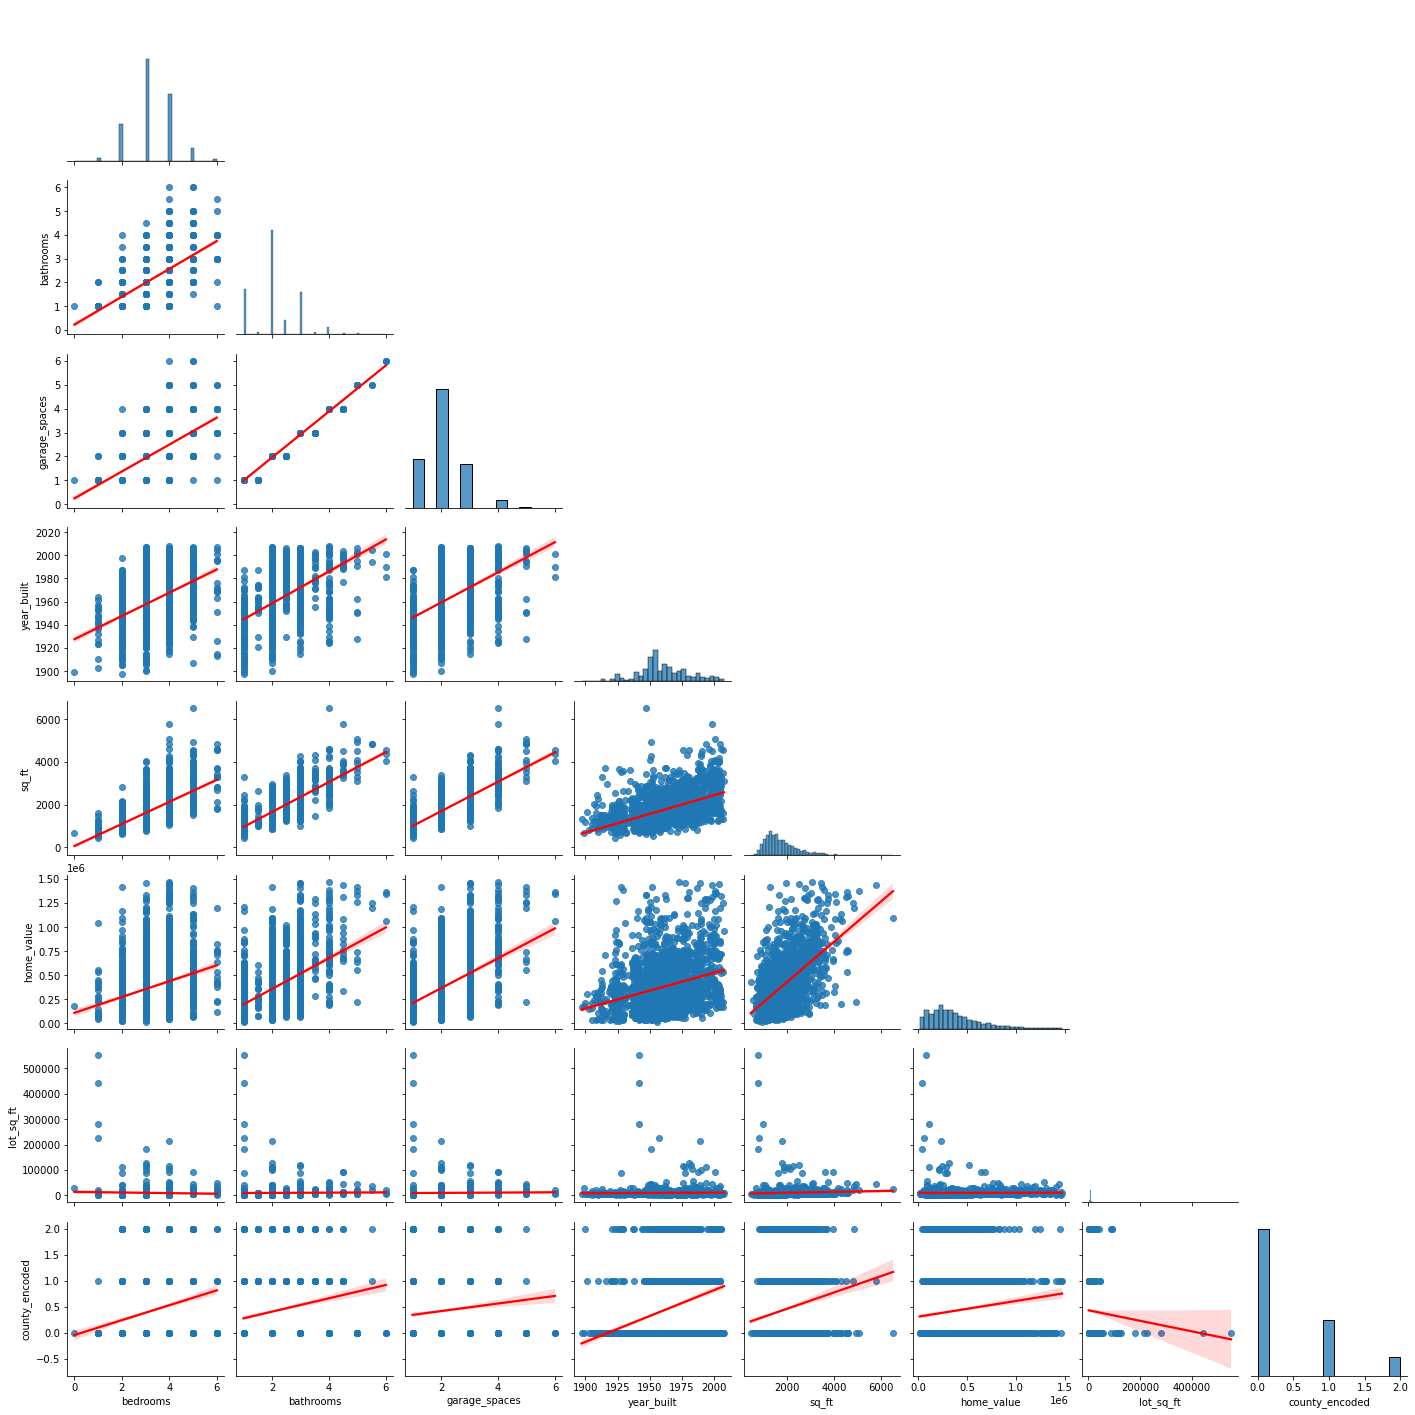

In [61]:
# Creating a snapshot of our data, variables, and their relationships
sns.pairplot(train.sample(2000), kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bedrooms        29715 non-null  int64   
 1   bathrooms       29715 non-null  float64 
 2   garage_spaces   29715 non-null  float64 
 3   year_built      29715 non-null  int64   
 4   location        29715 non-null  object  
 5   sq_ft           29715 non-null  int64   
 6   home_value      29715 non-null  int64   
 7   lot_sq_ft       29715 non-null  float64 
 8   decade_built    29715 non-null  category
 9   county_encoded  29715 non-null  int64   
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 2.3+ MB


In [63]:
cat_cols = ['bedrooms', 'bathrooms', 'garage_spaces', 'decade_built', 'location']
cont_cols = ['sq_ft', 'home_value', 'lot_sq_ft']

In [64]:
# Creating a plot loop that iterates through all combinations of variables
def plot_categorical_and_continuous_vars(train, cat_cols, cont_cols):
    train_sample = train.sample(5000)
    for cont in cont_cols:
        for cat in cat_cols:
            fig = plt.figure(figsize= (20, 10))
            fig.suptitle(f'{cont} vs {cat}')
            

            plt.subplot(131)
            sns.stripplot(data=train_sample, x = cat, y = cont)
           

            plt.subplot(1, 3, 3)
            sns.boxplot(data = train_sample, x = cont, hue = cat)
            
            
            plt.subplot(1, 3, 2)
            sns.barplot(data = train_sample, x = cat, y = cont)

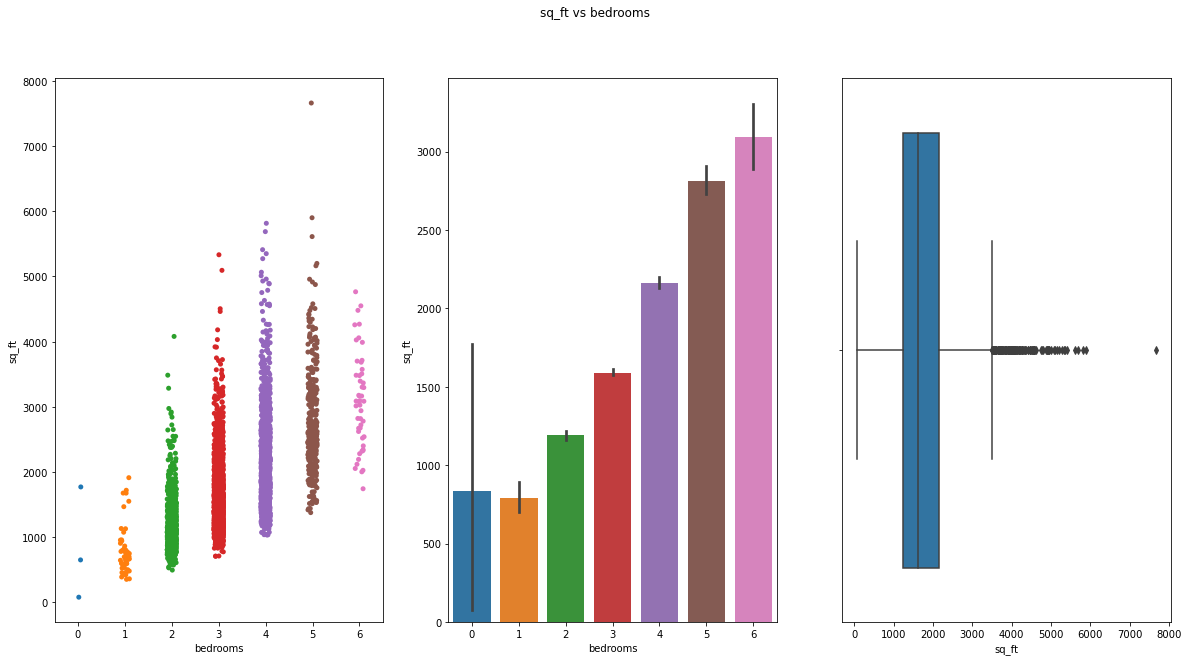

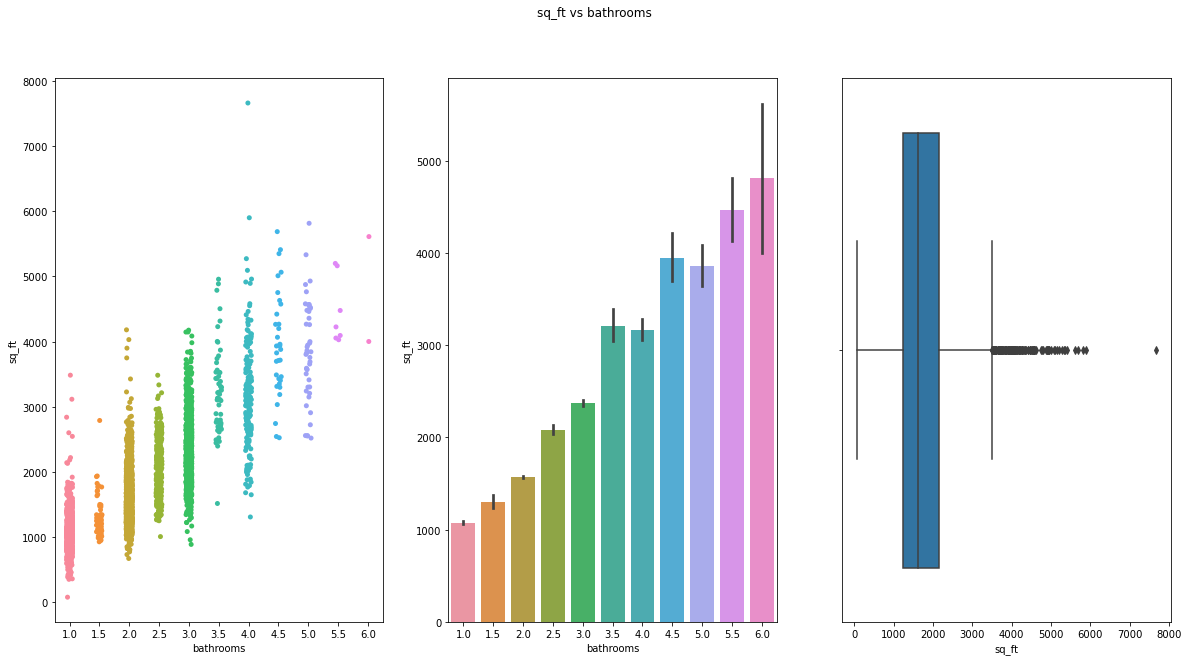

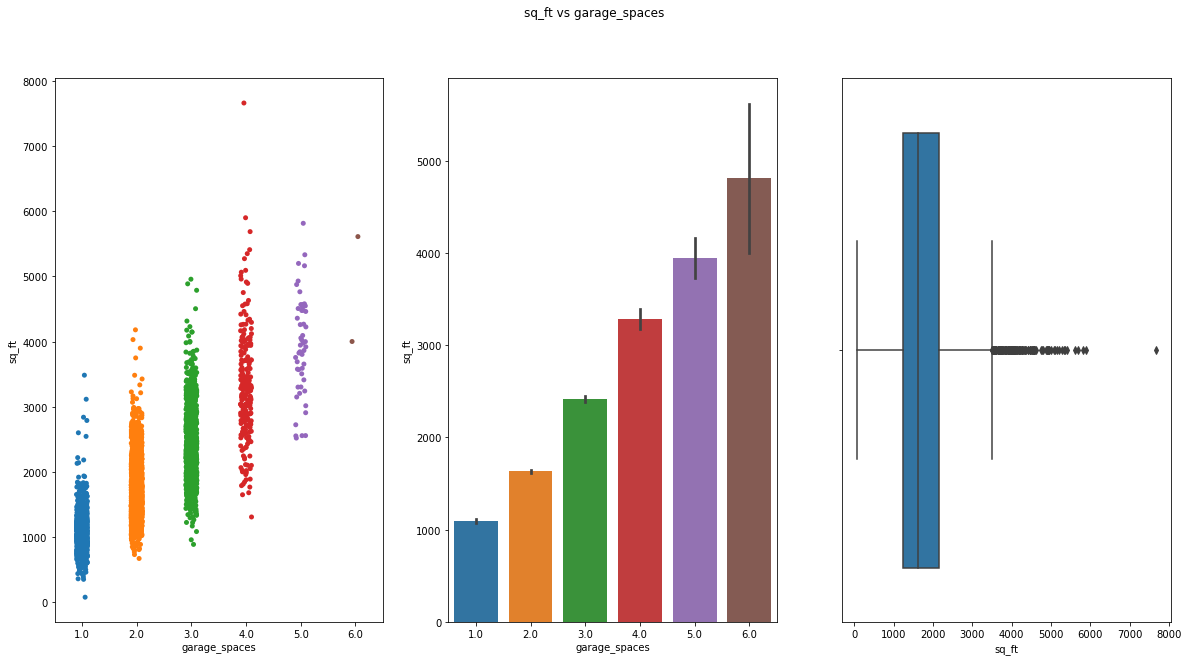

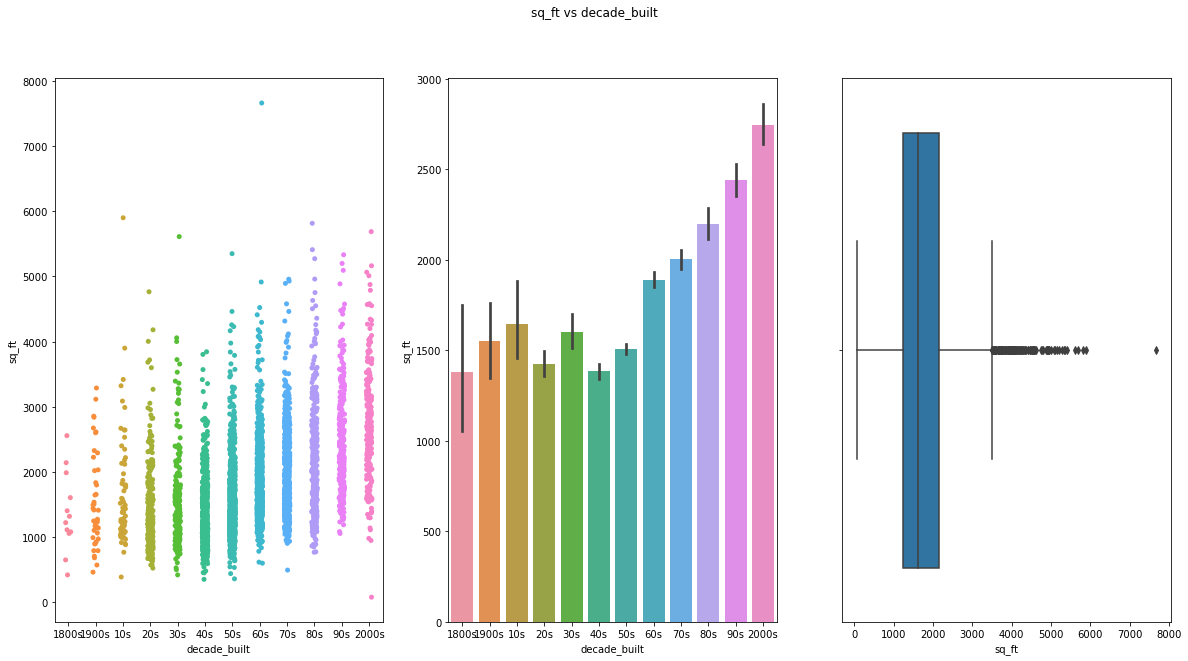

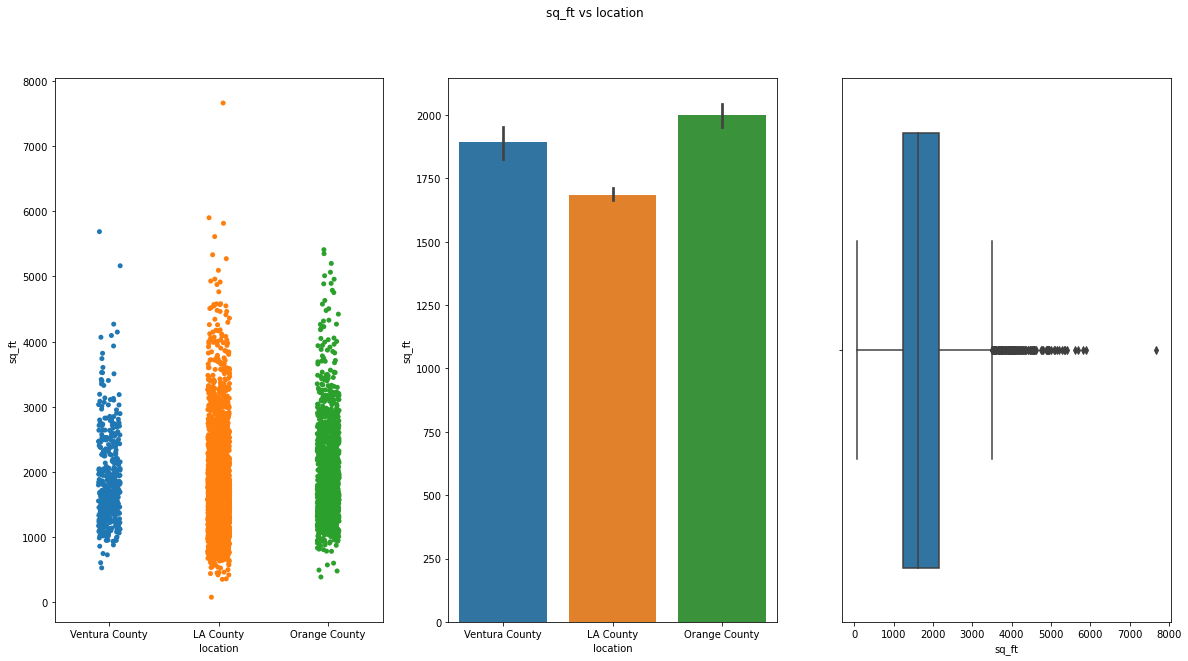

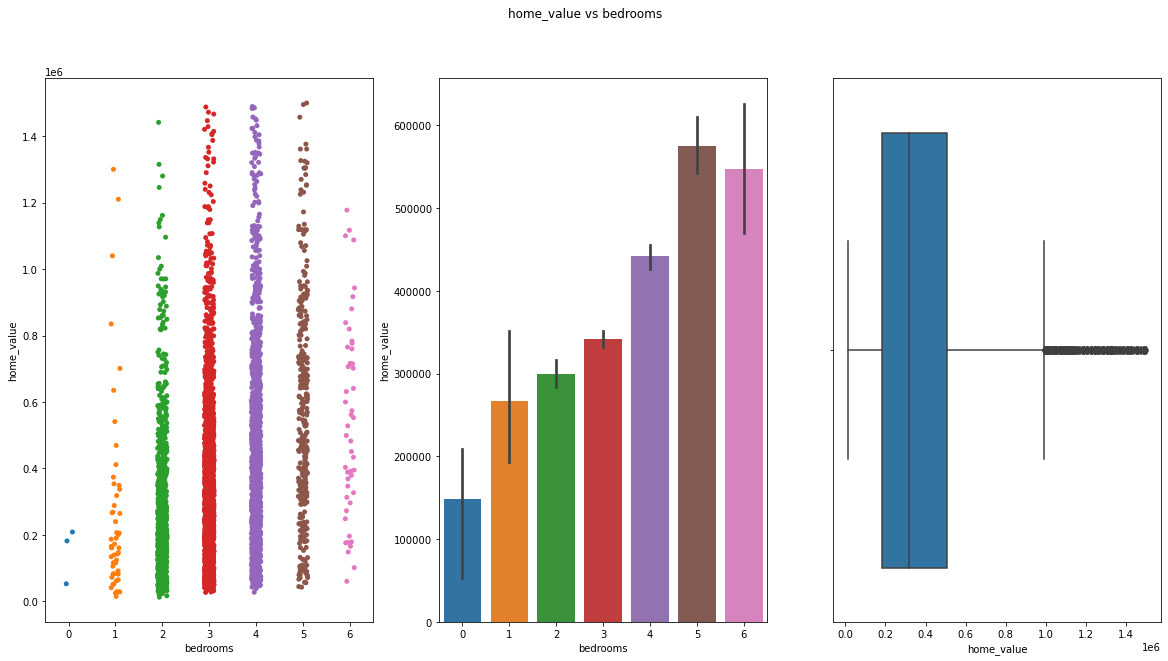

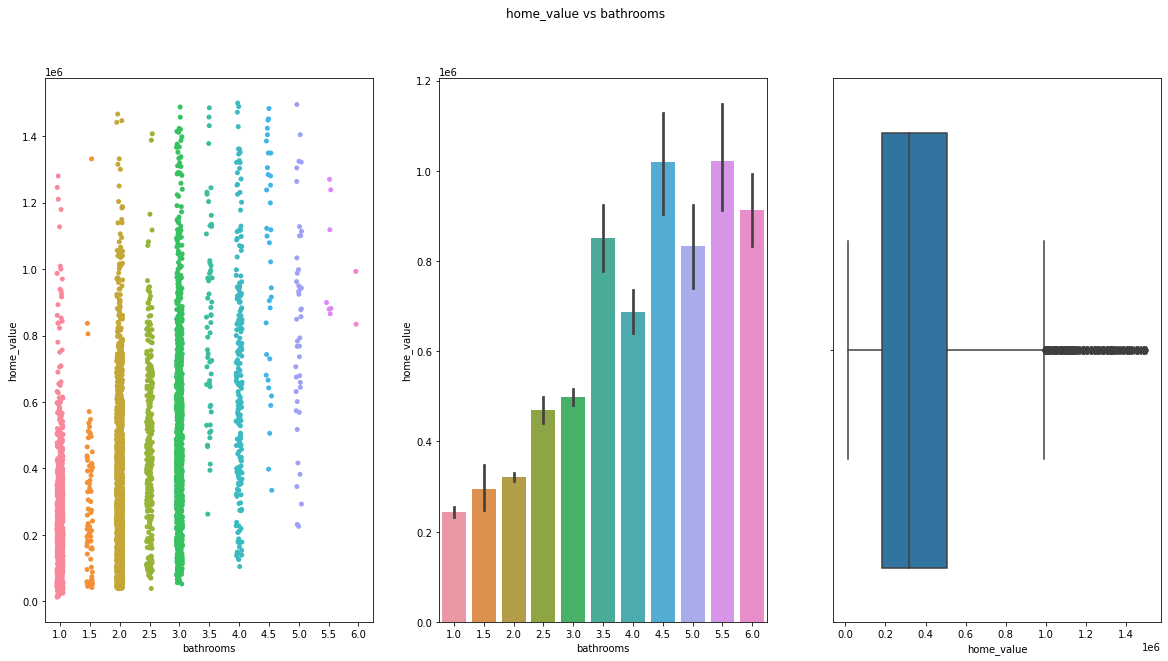

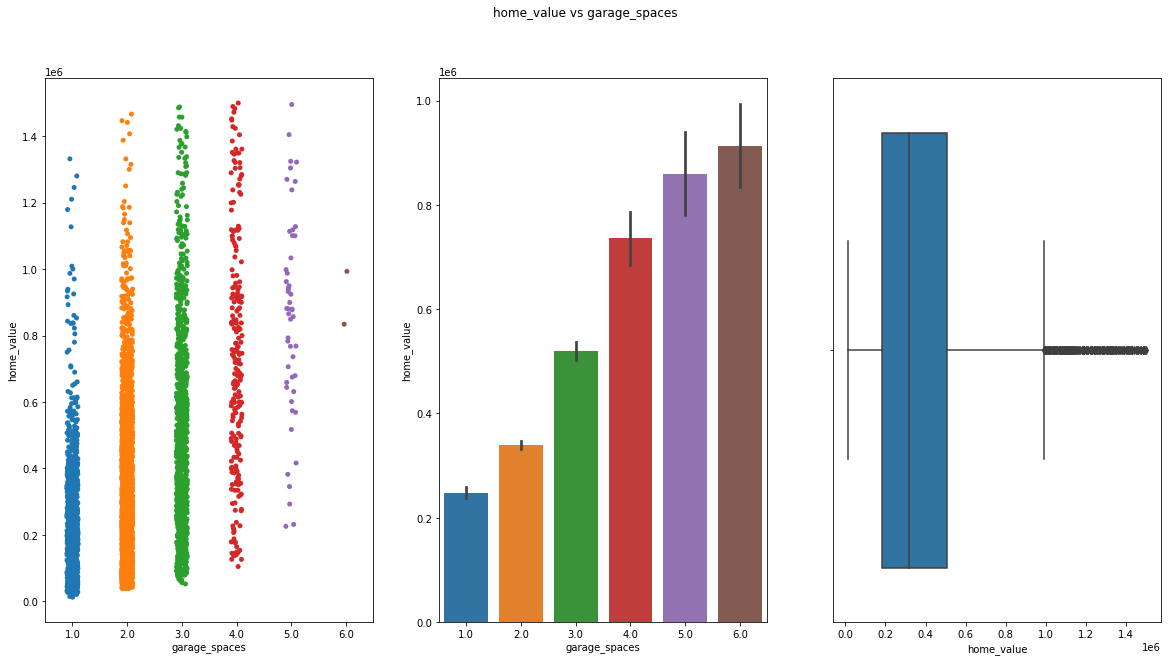

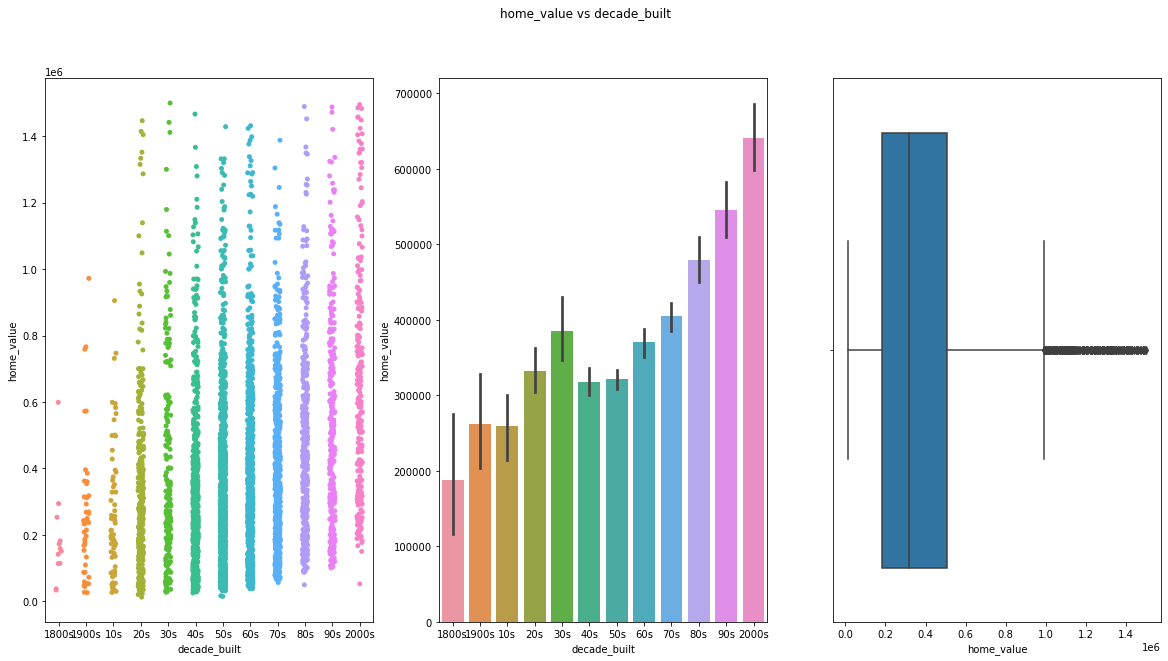

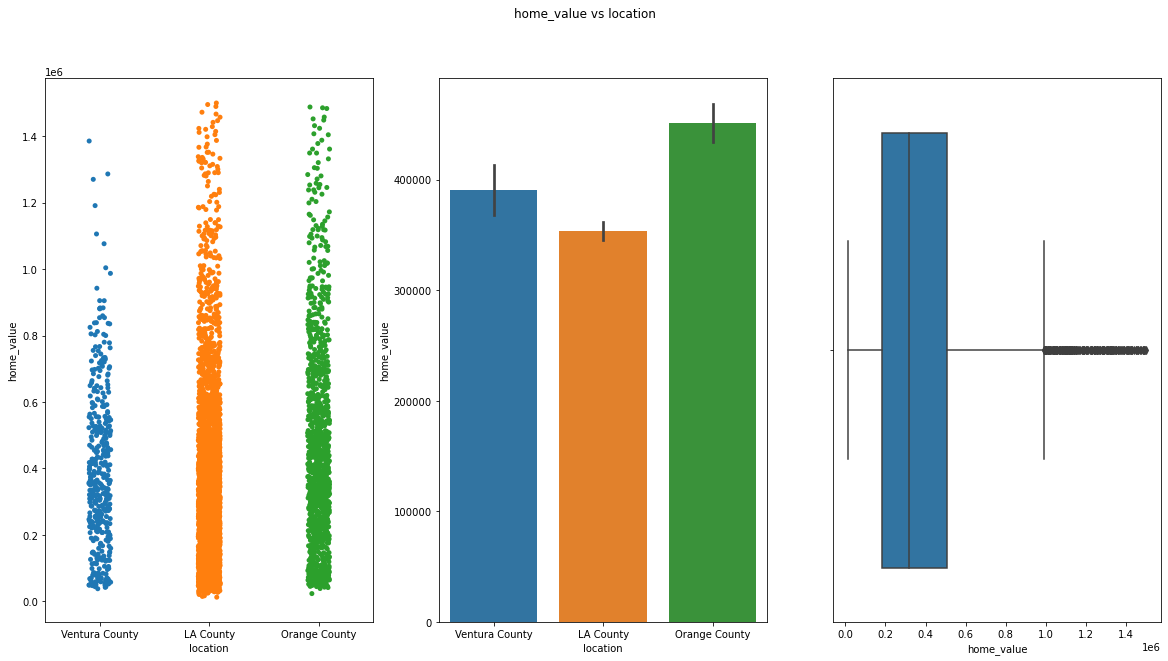

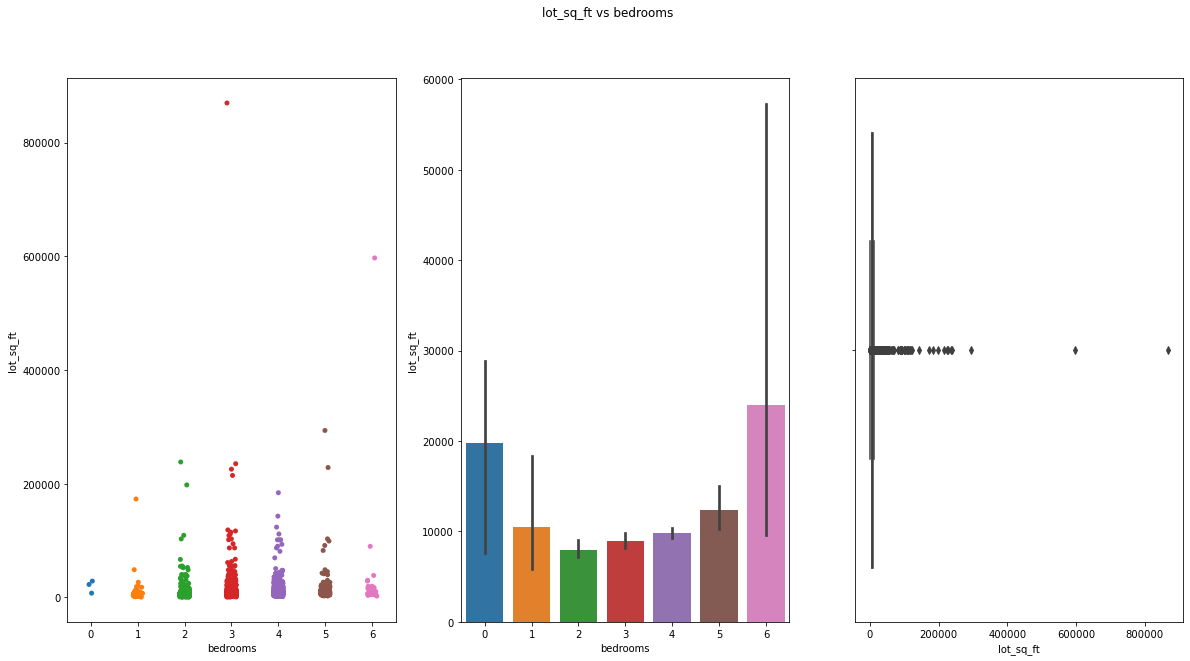

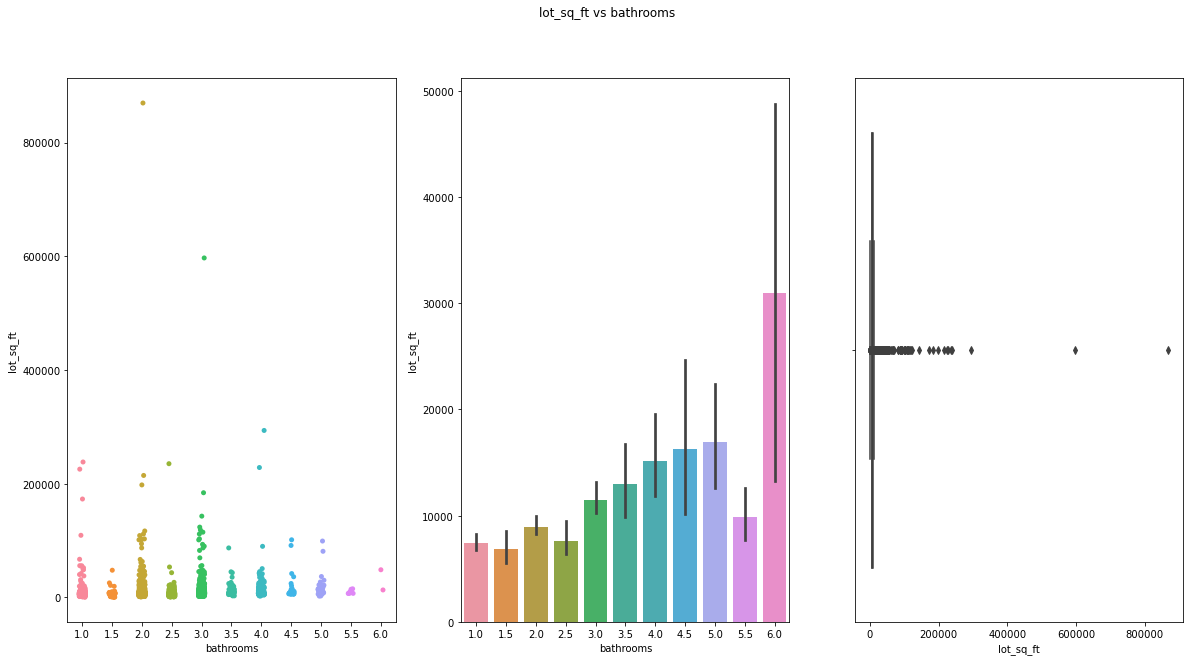

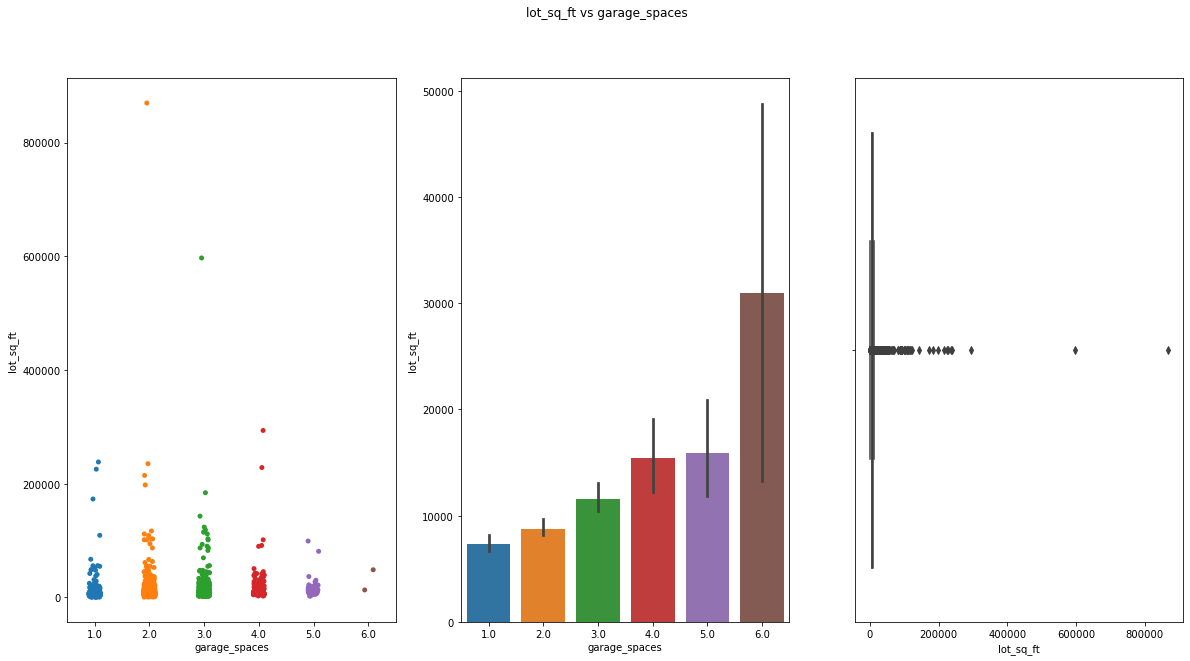

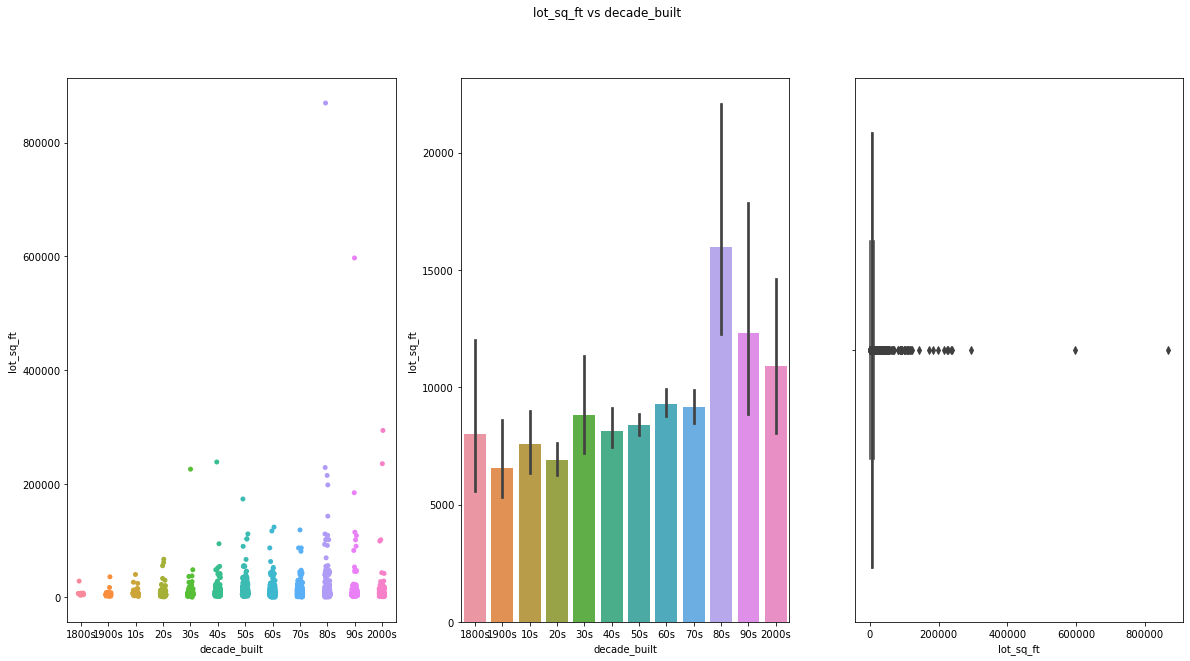

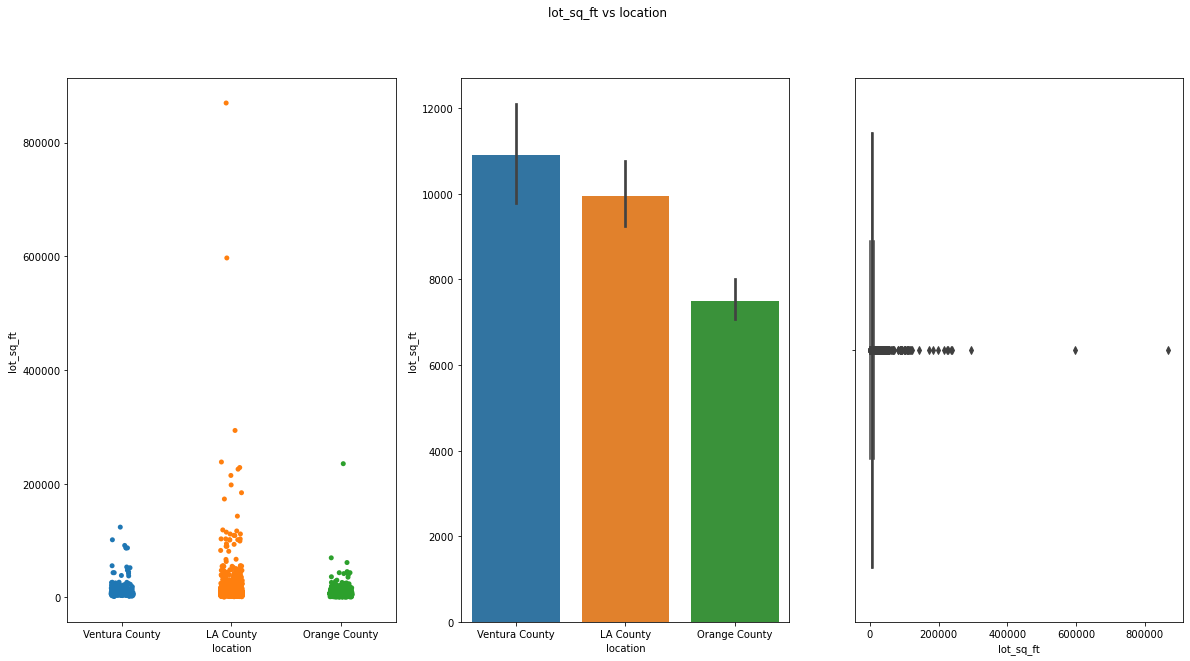

In [65]:
# Visualizing relationships between cat and cont variables:
plot_categorical_and_continuous_vars(train, cat_cols, cont_cols)

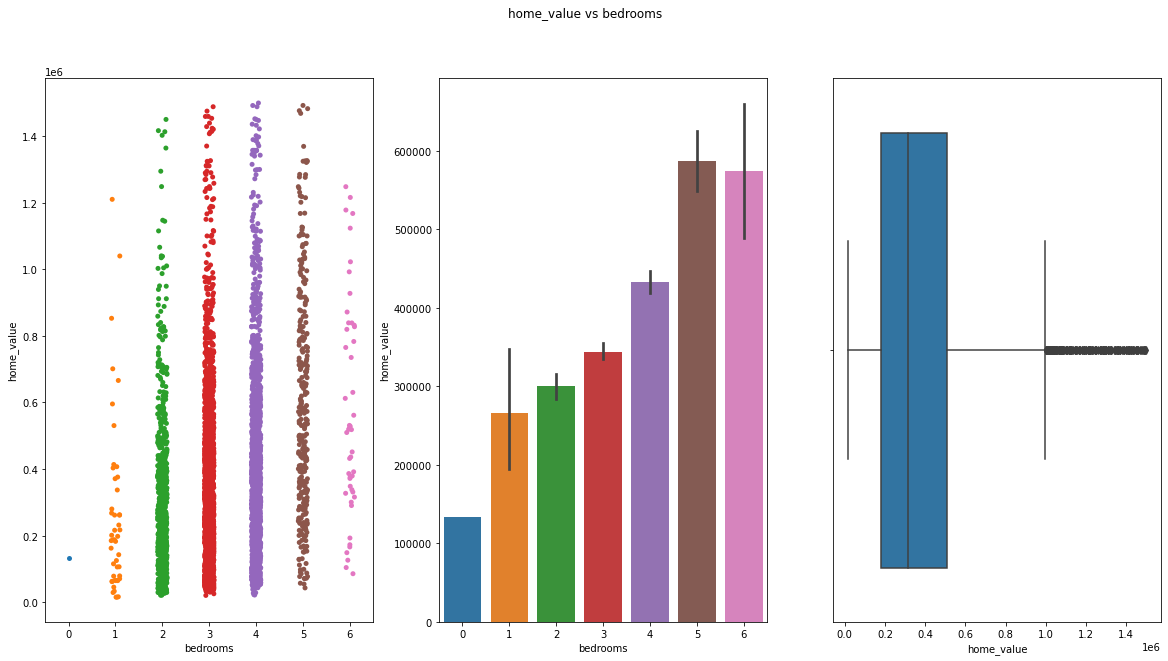

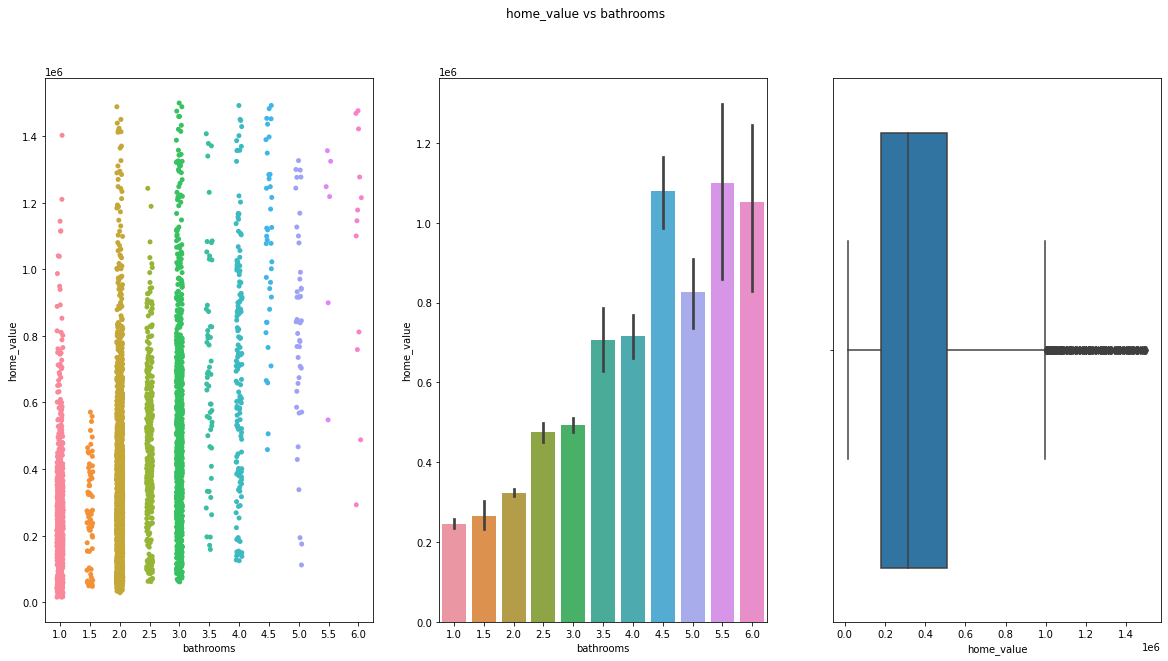

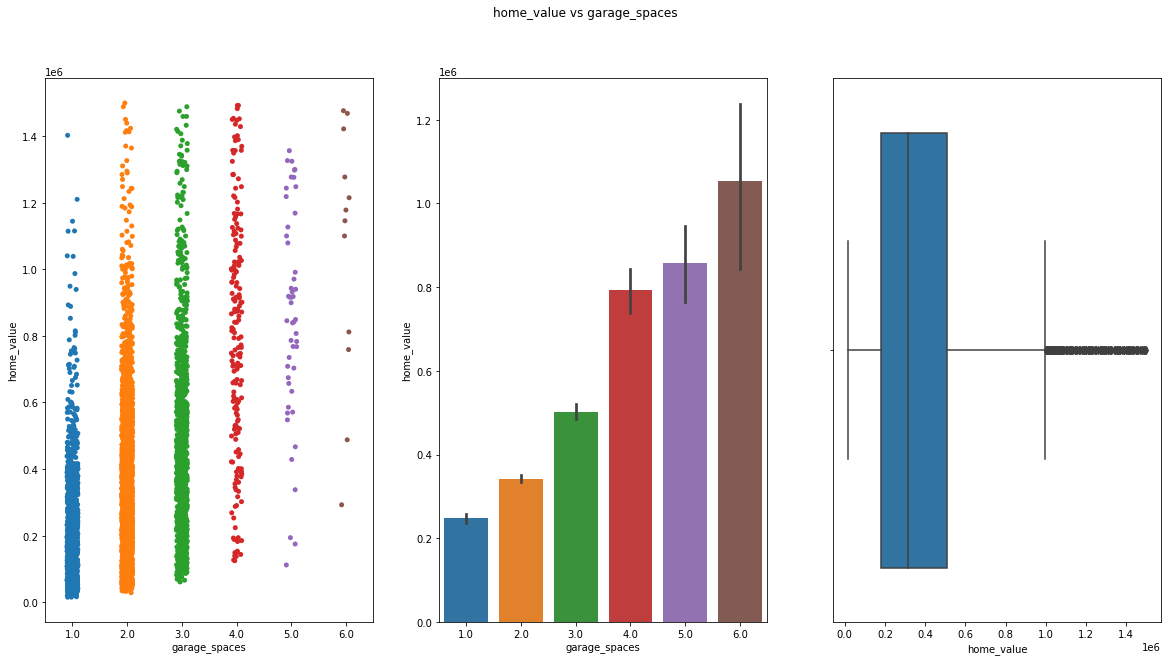

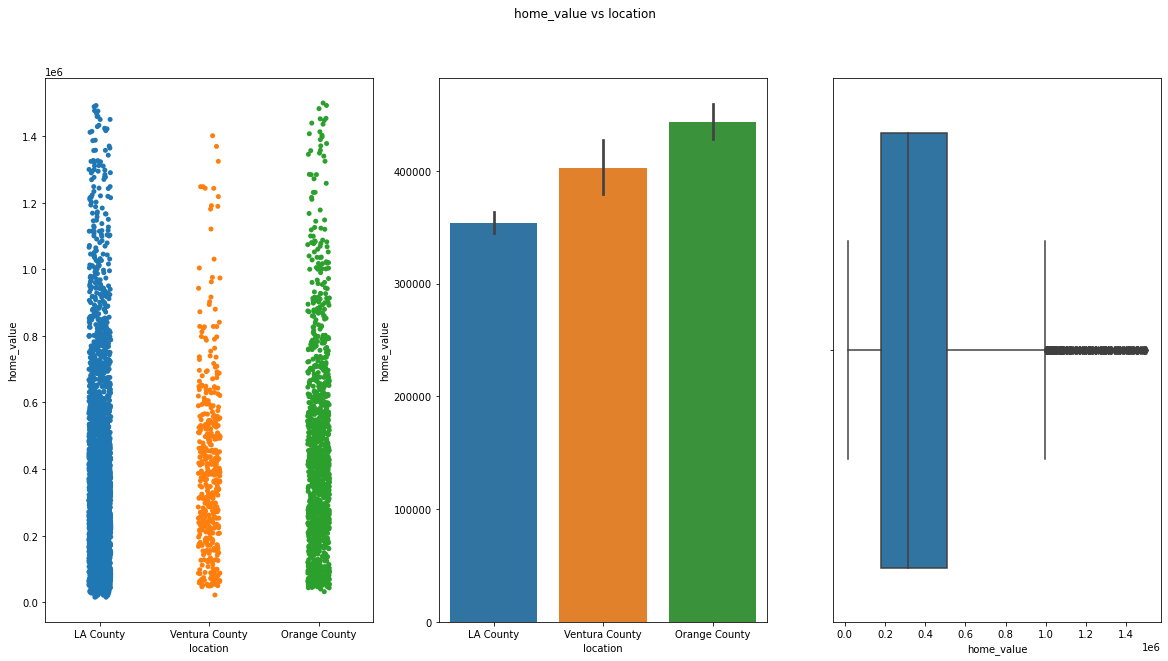

In [66]:
# Plot for Final Report
cat_cols = ['bedrooms', 'bathrooms', 'garage_spaces', 'location']
cont_cols = ['home_value']

plot_categorical_and_continuous_vars(train, cat_cols, cont_cols)

In [67]:
# Creating heatmap df
train_corr = train.corr()
train_corr

,bedrooms,bathrooms,garage_spaces,year_built,sq_ft,home_value,lot_sq_ft,county_encoded
bedrooms,1.000000,0.612553,0.601381,0.384099,0.610944,0.265847,0.002134,0.174063
bathrooms,0.612553,1.000000,0.983641,0.528790,0.813172,0.488590,0.016570,0.146096
garage_spaces,0.601381,0.983641,1.000000,0.484361,0.788173,0.465832,0.018407,0.071281
year_built,0.384099,0.528790,0.484361,1.000000,0.471959,0.277839,0.032785,0.347642
sq_ft,0.610944,0.813172,0.788173,0.471959,1.000000,0.562278,0.030476,0.153670
home_value,0.265847,0.488590,0.465832,0.277839,0.562278,1.000000,0.006145,0.109596
lot_sq_ft,0.002134,0.016570,0.018407,0.032785,0.030476,0.006145,1.000000,-0.013542
county_encoded,0.174063,0.146096,0.071281,0.347642,0.153670,0.109596,-0.013542,1.000000


<AxesSubplot:>

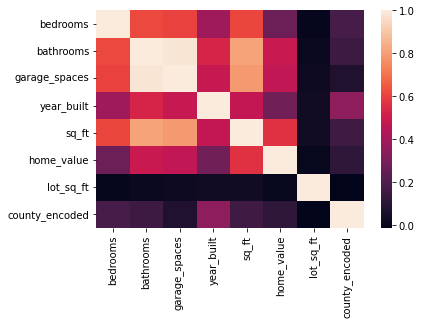

In [68]:
# Visualizing relationship between all variables using a heatmap
sns.heatmap(train_corr)

# Initial Hypotheses

#### 1. Does a higher number of bedrooms increase home value?

- Ho = More bedrooms translates to <= home value
- Ha = More bedrooms translates to > home value

#### 2. Does a higher number of bathrooms increase home value?

- Ho = More bathrooms translates to <= home value
- Ha = More bathrooms translates to > home value

#### 3. Do more garage spaces increase home value?

- Ho = More garage spaces translates to <= home value
- Ha = More garage spaces translates to > home value

#### 4. Does county location affect home value?

- Ho = Population Means of the Home Values for Orange county, LA County, and Ventura County are all equal
- Ha = Population Means of the Home Values for Orange county, LA County, and Ventura County are NOT all equal

#### 5. Does a higher square footage increase home value?

- Ho = More sq_ft translates to <= home value
- Ha = More sq_ft translates to > home value

#### 6. Does the decade a house is built affect home value? (ONLY IF TIME ALLOWS)

- Ho = Different decades == home value
- Ha = Different decades != home value

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   bedrooms        29715 non-null  int64   
 1   bathrooms       29715 non-null  float64 
 2   garage_spaces   29715 non-null  float64 
 3   year_built      29715 non-null  int64   
 4   location        29715 non-null  object  
 5   sq_ft           29715 non-null  int64   
 6   home_value      29715 non-null  int64   
 7   lot_sq_ft       29715 non-null  float64 
 8   decade_built    29715 non-null  category
 9   county_encoded  29715 non-null  int64   
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 2.3+ MB


### 1. Does a higher number of bedrooms increase home value?
- Ho = More bedrooms translates to <= home value
- Ha = More bedrooms translates to > home value

In [70]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(1000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)

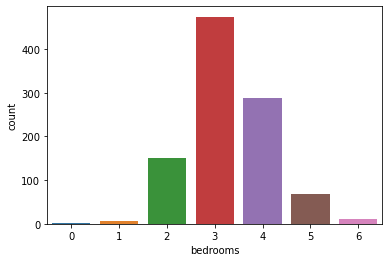

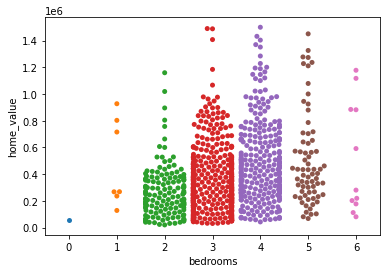

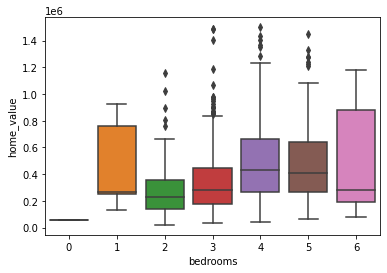

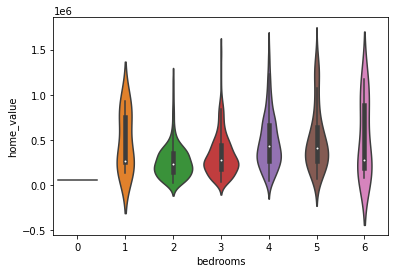

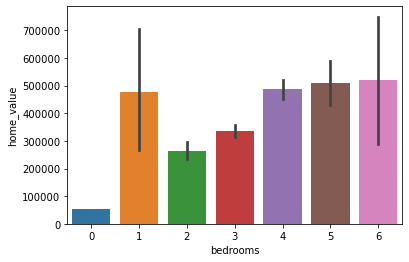

In [71]:
# Applying plot function to 'bedrooms' v. 'home_value'
plot_categorical_and_continuous_vars(train, 'bedrooms', 'home_value')

#### Statistical Analysis

In [72]:
# Use the scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
alpha = 0.05

r_bed , p_bed = pearsonr(x = train['bedrooms'], y = train['home_value'])

r_bed , p_bed

if p_bed < alpha:
    print('The number of bedrooms is correlated with home value.')
    print('The correlation coefficient is {}.'.format(r_bed))
else:
    print('The number of bedrooms is NOT correlated with home value.')

The number of bedrooms is correlated with home value.
The correlation coefficient is 0.2658468613001996.


#### Answer 1
Following our statistical test, we indicate that this feature is correlated with home value, meaning that there is statistical significance behind the claim that more bedrooms results in a higher home value. Thus we move forward with this feature.

### 2.  Does a higher number of bathrooms increase home value?
- Ho = More bathrooms translates to <= home value
- Ha = More bathrooms translates to > home value

In [73]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(1000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)

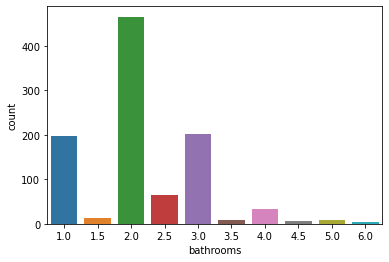

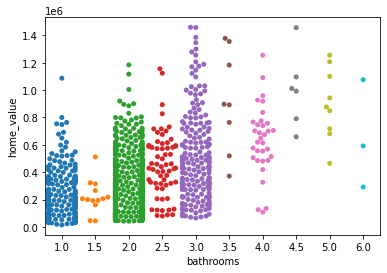

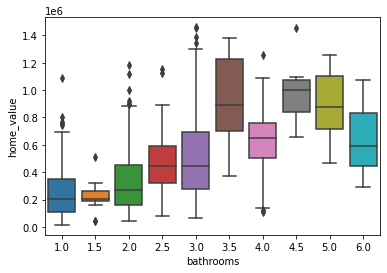

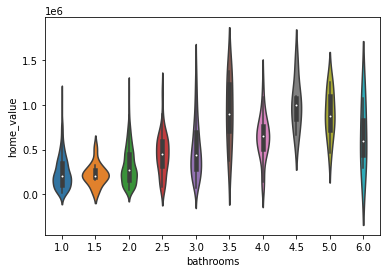

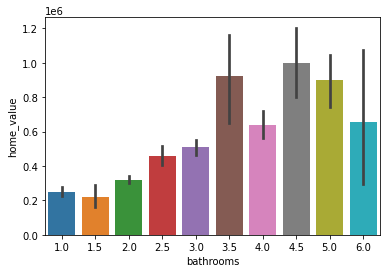

In [74]:
plot_categorical_and_continuous_vars(train, 'bathrooms', 'home_value')

#### Statistical Analysis

In [75]:
# Use the scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
alpha = 0.05

r_bath , p_bath = pearsonr(x = train['bathrooms'], y = train['home_value'])

r_bath , p_bath

if p_bath < alpha:
    print('The number of bathrooms is correlated with home value.')
    print('The correlation coefficient is {}.'.format(r_bath))
else:
    print('The number of bathrooms is NOT correlated with home value.')

The number of bathrooms is correlated with home value.
The correlation coefficient is 0.48859033755382986.


#### Answer 2
Following our statistical test, we indicate that this feature is correlated with home value, meaning that there is statistical significance behind the claim that more bathrooms results in a higher home value. Thus we move forward with this feature.

### 3. Do more garage spaces increase home value?

- Ho = More garage spaces translates to <= home value
- Ha = More garage spaces translates to > home value

In [76]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(1000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)

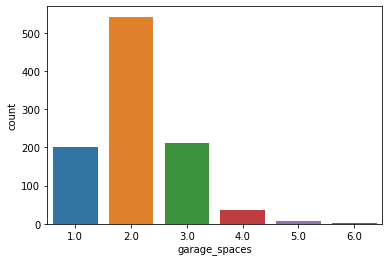

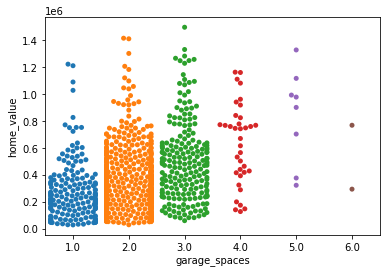

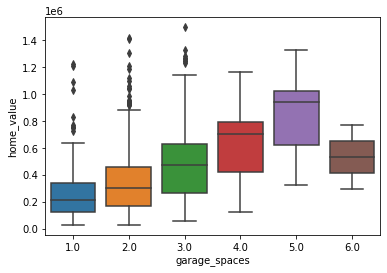

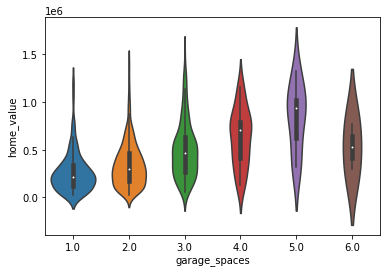

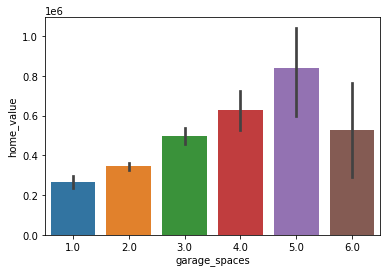

In [77]:
plot_categorical_and_continuous_vars(train, 'garage_spaces', 'home_value')

#### Statistical Analysis

In [78]:
# Use the scipy stats function pearsonr to calculate the correlation coefficient and the p-value.
alpha = 0.05

r_garage , p_garage = pearsonr(x = train['garage_spaces'], y = train['home_value'])

r_garage , p_garage

if p_garage < alpha:
    print('The number of garage spaces is correlated with home value.')
    print('The correlation coefficient is {}.'.format(r_garage))
else:
    print('The number of garage spaces is NOT correlated with home value.')

The number of garage spaces is correlated with home value.
The correlation coefficient is 0.4658324011706713.


#### Answer 3
Following our statistical test, we indicate that this feature is correlated with home value, meaning that there is statistical significance behind the claim that more garage spaces results in a higher home value. Thus we move forward with this feature.

### 4. Does county location affect home value?

- Ho = Population Means of the Home Values for Orange county, LA County, and Ventura County are all equal
- Ha = Population Means of the Home Values for Orange county, LA County, and Ventura County are NOT all equal

In [79]:
# Define function which plots a categorical and continuous var
def plot_categorical_and_continuous_vars(df, categorical, continuous):
    df_sample = df.sample(1000)
    plt.figure()
    sns.countplot(x=categorical, data=df_sample)
    plt.figure()
    sns.swarmplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.boxplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.violinplot(x=categorical, y=continuous, data=df_sample)
    plt.figure()
    sns.barplot(x=categorical, y=continuous, data=df_sample)

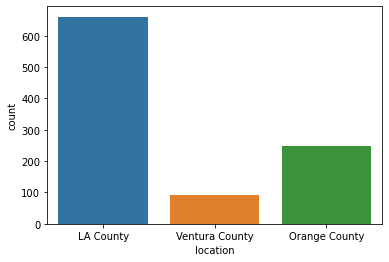

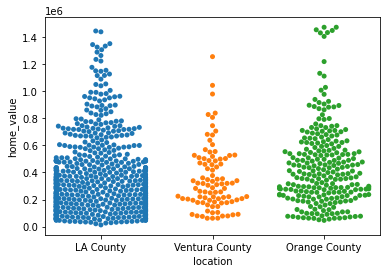

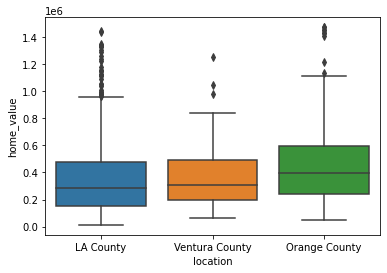

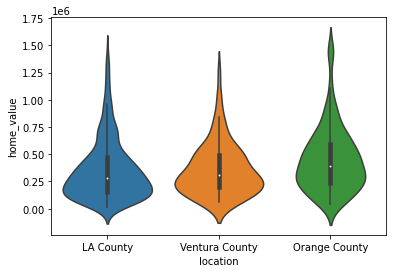

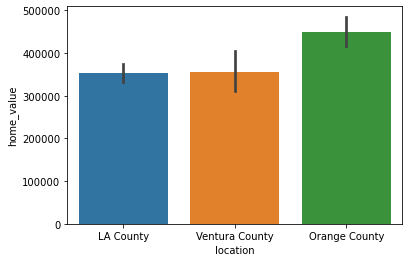

In [80]:
plot_categorical_and_continuous_vars(train, 'location', 'home_value')

#### Statistical Analysis

In [81]:
train['location'].value_counts()

LA County         19850
Orange County      7267
Ventura County     2598
Name: location, dtype: int64

In [82]:
Orange = train[train.location == 'Orange County'].home_value
LA = train[train.location == 'LA County'].home_value
Ventura = train[train.location == 'Ventura County'].home_value

In [83]:
len(Orange)

7267

In [84]:
# ANOVA test for comparing 3 separate cat vars
f, p = stats.f_oneway(Orange, LA, Ventura)
f, p

print(f'f-statistic by ANOVA Test: {f}, p-value: {p}')

# set alpha : 0.05
if p < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

f-statistic by ANOVA Test: 292.7573652142797, p-value: 1.2406052252144863e-126
We can reject the null hypothesis


In [85]:
# Due to questionable normality of distribution,
# I'll conduct the Kruskal-Wallis H-test

H, p = stats.kruskal(Orange, LA, Ventura)
H, p

print(f'H-statistic by Kruskal-Wallis Test: {H}, p-value: {p}')

# set alpha : 0.05
if p < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')


H-statistic by Kruskal-Wallis Test: 769.658729596666, p-value: 7.425580212004322e-168
We can reject the null hypothesis


#### Answer 4
Following our statistical test, we reject the null, meaning that there is statistical significance behind the claim that the population means of the Home Values for each county are NOT equal. Thus we move forward with this feature.

### 5. Does a higher square footage increase home value?

- Ho = More sq_ft translates to <= home value
- Ha = More sq_ft translates to > home value

In [86]:
# Define function which plots two continuous vars
def plot_continuous_and_continuous_vars(df, continuous1, continuous):
    df_sample = df.sample(1000)
    plt.figure()
    sns.relplot(x=continuous1, y=continuous, data=df_sample, kind='scatter')
    plt.figure()
    sns.lmplot(x=continuous1, y=continuous, data=df_sample, scatter=True, hue=None)
    plt.figure()
    sns.jointplot(x=continuous1, y=continuous, data=df_sample, kind='scatter')

<Figure size 432x288 with 0 Axes>

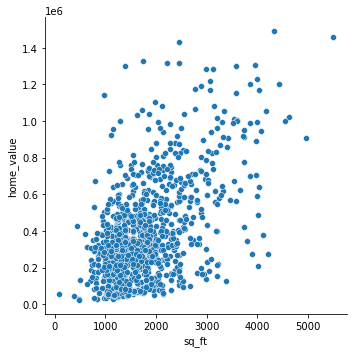

<Figure size 432x288 with 0 Axes>

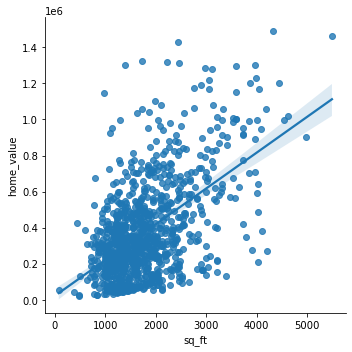

<Figure size 432x288 with 0 Axes>

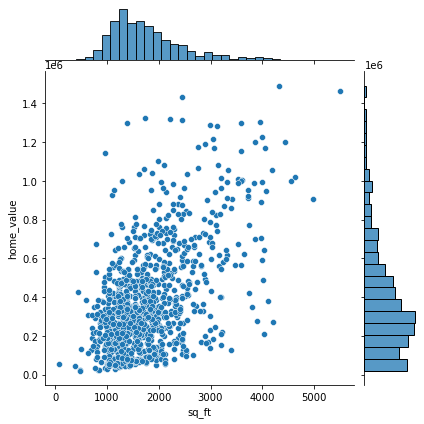

In [87]:
plot_continuous_and_continuous_vars(train, 'sq_ft', 'home_value')

#### Statistical Analysis

In [88]:
x_train.head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,lot_sq_ft,decade_built,county_encoded
52851,4,3.5,3.0,2006,Orange County,2499,3274.0,2000s,1
48185,2,3.0,3.0,1938,LA County,2186,7325.0,30s,0
25784,3,3.0,3.0,1951,LA County,1860,6251.0,50s,0
45999,3,2.0,2.0,1950,LA County,1890,8092.0,50s,0
21886,2,2.0,2.0,1946,LA County,1317,6217.0,40s,0


In [89]:
# Use the scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r_sf, p_sf = pearsonr(train['sq_ft'], train['home_value'])

r_sf, p_sf

print(f'Correlation Coefficient by Pearson Test: {r_sf}, p-value: {p_sf}')

# set alpha : 0.05
if p_sf < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.5622779055862923, p-value: 0.0
We can reject the null hypothesis


In [90]:
# Since my variables are not normally distributed, I should really choose Spearman instead.

r_sf, p_sf = spearmanr(train['sq_ft'], train['home_value'])
r_sf, p_sf

print(f'Correlation Coefficient by Spearman Test: {r_sf}, p-value: {p_sf}')

# set alpha : 0.05
if p_sf < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis') 

Correlation Coefficient by Spearman Test: 0.479272798268537, p-value: 0.0
We can reject the null hypothesis


#### Answer 5
Following our statistical test, we reject the null, meaning that there is statistical significance behind the claim that the population means of the Home Values for each county are NOT equal. Thus we move forward with this feature.

**Takeaways**
- `bedrooms` is proven to be statistically significant
- `bathrooms` is proven to be statistically significant
- `garage_spaces` is proven to be statistically significant
- `location` is proven to be statistically significant
- `sq_ft` is proven to be statistically significant

# Modeling

### Scaling 

In [91]:
# Removing non-scalable features for scaling
x_train_to_scale = x_train.drop(columns=['location','decade_built', 'year_built', 'lot_sq_ft'])
x_validate_to_scale = x_validate.drop(columns=['location','decade_built', 'year_built', 'lot_sq_ft'])
x_test_to_scale = x_test.drop(columns=['location','decade_built', 'year_built', 'lot_sq_ft'])

In [92]:
x_train_to_scale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        29715 non-null  int64  
 1   bathrooms       29715 non-null  float64
 2   garage_spaces   29715 non-null  float64
 3   sq_ft           29715 non-null  int64  
 4   county_encoded  29715 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 1.4 MB


##### MinMax Scaler

In [93]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(x_train_to_scale)

train_mms = mms.transform(x_train_to_scale)

In [94]:
#Import dependencies
from sklearn.preprocessing import MinMaxScaler

#Define function to scale all data based on the train subset
def scale_data(train, validate, test):
    
    scale_columns = ['bedrooms', 'bathrooms', 'garage_spaces', 'sq_ft']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    mms = MinMaxScaler()
    
    mms.fit(train[scale_columns])
    
    train_scaled[scale_columns] = mms.transform(train[scale_columns])
    validate_scaled[scale_columns] = mms.transform(validate[scale_columns])
    test_scaled[scale_columns] = mms.transform(test[scale_columns])
    
    return train_scaled, validate_scaled, test_scaled

In [95]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [96]:
train_scaled.head()

,bedrooms,bathrooms,garage_spaces,year_built,location,sq_ft,home_value,lot_sq_ft,decade_built,county_encoded
52851,0.666667,0.5,0.4,2006,Orange County,0.284022,908648,3274.0,2000s,1
48185,0.333333,0.4,0.4,1938,LA County,0.247302,120760,7325.0,30s,0
25784,0.500000,0.4,0.4,1951,LA County,0.209057,136808,6251.0,50s,0
45999,0.500000,0.2,0.2,1950,LA County,0.212576,297111,8092.0,50s,0
21886,0.333333,0.2,0.2,1946,LA County,0.145354,327137,6217.0,40s,0


#### 2 Options: drop lot_sq_ft OR scale lot_sq_ft 

In [97]:
train_scaled = train_scaled.drop(columns = ['location', 'lot_sq_ft', 'decade_built'])
validate_scaled = validate_scaled.drop(columns = ['location', 'lot_sq_ft', 'decade_built'])
test_scaled = test_scaled.drop(columns = ['location', 'lot_sq_ft', 'decade_built'])

In [98]:
# scale_columns = ['bedrooms', 'bathrooms', 'garage_spaces', 'sq_ft', 'lot_sq_ft']

In [99]:
train_scaled.head()

,bedrooms,bathrooms,garage_spaces,year_built,sq_ft,home_value,county_encoded
52851,0.666667,0.5,0.4,2006,0.284022,908648,1
48185,0.333333,0.4,0.4,1938,0.247302,120760,0
25784,0.500000,0.4,0.4,1951,0.209057,136808,0
45999,0.500000,0.2,0.2,1950,0.212576,297111,0
21886,0.333333,0.2,0.2,1946,0.145354,327137,0


In [100]:
# Splitting train, validate, and test dfs on x and y FOR SCALED DF
x_train_scaled = train_scaled.drop(columns=['home_value'])
x_validate_scaled = validate_scaled.drop(columns=['home_value'])
x_test_scaled = test_scaled.drop(columns=['home_value'])

y_train_scaled = train_scaled['home_value']
y_validate_scaled = validate_scaled['home_value']
y_test_scaled = test_scaled['home_value']

In [101]:
x_train_scaled.shape

(29715, 6)

In [102]:
x_train_scaled.head()

,bedrooms,bathrooms,garage_spaces,year_built,sq_ft,county_encoded
52851,0.666667,0.5,0.4,2006,0.284022,1
48185,0.333333,0.4,0.4,1938,0.247302,0
25784,0.500000,0.4,0.4,1951,0.209057,0
45999,0.500000,0.2,0.2,1950,0.212576,0
21886,0.333333,0.2,0.2,1946,0.145354,0


In [103]:
x_validate_scaled.shape

(12735, 6)

In [104]:
x_validate_scaled.head()

,bedrooms,bathrooms,garage_spaces,year_built,sq_ft,county_encoded
4001,0.333333,0.0,0.0,1941,0.155443,0
29450,0.500000,0.2,0.2,1891,0.153449,0
47104,0.333333,0.0,0.0,1946,0.111450,0
37061,0.666667,0.2,0.2,1955,0.160253,0
42017,0.500000,0.2,0.2,1981,0.157672,0


### Begin Modeling

#### Baseline

In [105]:
#Establish baselines for the train and validation datasets
baseline = train['home_value'].mean()

train['baseline'] = baseline
validate['baseline'] = baseline
test['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train['home_value'], train.baseline))
validate_rmse = sqrt(mean_squared_error(validate['home_value'], validate.baseline))
test_rmse = sqrt(mean_squared_error(test['home_value'], test.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))
print('Test baseline RMSE: {}.'.format(test_rmse))

Train baseline RMSE: 272118.84506691294.
Validation baseline RMSE: 268096.9138598306.
Test baseline RMSE: 270460.22757535306.


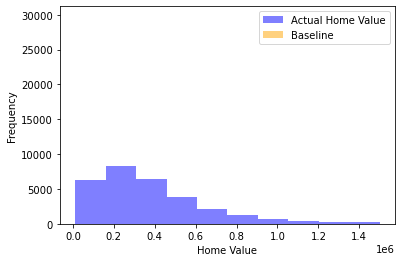

In [106]:
#Plot my train baseline against the actual home_value distribution
plt.hist(train['home_value'], color='blue', alpha=0.5, label='Actual Home Value')
plt.hist(train.baseline, color='orange', alpha=0.5, label='Baseline')
plt.xlabel('Home Value')
plt.ylabel('Frequency')
plt.legend()

In [107]:
train_predictions = pd.DataFrame({
    'actual': train['home_value'],
    'baseline': baseline
}) 

In [108]:
train_predictions.head()

,actual,baseline
52851,908648,377672.367962
48185,120760,377672.367962
25784,136808,377672.367962
45999,297111,377672.367962
21886,327137,377672.367962


In [109]:
predictions = pd.DataFrame({
    'actual': validate['home_value'],
    'baseline': baseline
}) 

In [110]:
predictions.head()

,actual,baseline
4001,765900,377672.367962
29450,239885,377672.367962
47104,219324,377672.367962
37061,509000,377672.367962
42017,160408,377672.367962


#### Fitting Linear Regression

In [111]:
x_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        29715 non-null  float64
 1   bathrooms       29715 non-null  float64
 2   garage_spaces   29715 non-null  float64
 3   year_built      29715 non-null  int64  
 4   sq_ft           29715 non-null  float64
 5   county_encoded  29715 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 1.6 MB


In [112]:
#Create an instance of the model and fit it to my data
lm = LinearRegression().fit(x_train_scaled, y_train_scaled)

In [113]:
train_predictions['simple_lm'] = lm.predict(x_train_scaled)
predictions['simple_lm'] = lm.predict(x_validate_scaled)

In [114]:
train_predictions.head()

,actual,baseline,simple_lm
52851,908648,377672.367962,580779.779790
48185,120760,377672.367962,552226.789288
25784,136808,377672.367962,440632.193470
45999,297111,377672.367962,399567.949886
21886,327137,377672.367962,336383.198649


In [115]:
predictions.head()

,actual,baseline,simple_lm
4001,765900,377672.367962,306647.605400
29450,239885,377672.367962,309801.964769
47104,219324,377672.367962,233581.987101
37061,509000,377672.367962,265824.376547
42017,160408,377672.367962,305204.472467


#### Fitting Lasso-Lars Regression

In [116]:
# Starting at alpha = 1.0

# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_1'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_1'] = lars.predict(x_validate_scaled)

In [117]:
# alpha = 0.5

# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_05'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_05'] = lars.predict(x_validate_scaled)

In [118]:
# alpha = 2

# create the model object
lars = LassoLars(alpha=2)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_2'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_2'] = lars.predict(x_validate_scaled)

In [119]:
train_predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2
52851,908648,377672.367962,580779.779790,575661.626933,578220.703361,570543.474076
48185,120760,377672.367962,552226.789288,551000.085004,551613.437146,549773.380721
25784,136808,377672.367962,440632.193470,440184.724244,440408.458857,439737.255018
45999,297111,377672.367962,399567.949886,399630.055990,399599.002938,399692.162095
21886,327137,377672.367962,336383.198649,335882.967849,336133.083249,335382.737048


In [120]:
predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2
4001,765900,377672.367962,306647.605400,306519.270841,306583.438121,306390.936283
29450,239885,377672.367962,309801.964769,307673.498190,308737.731480,305545.031611
47104,219324,377672.367962,233581.987101,233589.104135,233585.545618,233596.221169
37061,509000,377672.367962,265824.376547,266362.483577,266093.430062,266900.590606
42017,160408,377672.367962,305204.472467,306329.506243,305766.989355,307454.540018


#### Fitting TweediRegressor (Generalized Linear Model, GLM)

In [121]:
# Start with power = 0 (assuming Normal Distribution)
# create the model object
##### why is alpha=1 ???????
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data
glm.fit(x_train_scaled, y_train_scaled)

# predict train, add to df
train_predictions['glm_p_0'] = glm.predict(x_train_scaled)

# predict validate, add to df
predictions['glm_p_0'] = glm.predict(x_validate_scaled)

In [122]:
# Now assuming Poisson Distribution, power = 1
# create the model object
glm = TweedieRegressor(power=1, alpha=1)

# fit the model to our training data
glm.fit(x_train_scaled, y_train_scaled)

# predict train, add to df
train_predictions['glm_p_1'] = glm.predict(x_train_scaled)

# predict validate, add to df
predictions['glm_p_1'] = glm.predict(x_validate_scaled)

In [123]:
train_predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2,glm_p_0,glm_p_1
52851,908648,377672.367962,580779.779790,575661.626933,578220.703361,570543.474076,543356.622055,377672.367962
48185,120760,377672.367962,552226.789288,551000.085004,551613.437146,549773.380721,305012.124544,377672.367962
25784,136808,377672.367962,440632.193470,440184.724244,440408.458857,439737.255018,350094.518514,377672.367962
45999,297111,377672.367962,399567.949886,399630.055990,399599.002938,399692.162095,340885.243411,377672.367962
21886,327137,377672.367962,336383.198649,335882.967849,336133.083249,335382.737048,325553.529590,377672.367962


In [124]:
train_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29715 entries, 52851 to 44009
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   actual           29715 non-null  int64  
 1   baseline         29715 non-null  float64
 2   simple_lm        29715 non-null  float64
 3   lasso_lars_a_1   29715 non-null  float64
 4   lasso_lars_a_05  29715 non-null  float64
 5   lasso_lars_a_2   29715 non-null  float64
 6   glm_p_0          29715 non-null  float64
 7   glm_p_1          29715 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 2.0 MB


In [125]:
predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2,glm_p_0,glm_p_1
4001,765900,377672.367962,306647.605400,306519.270841,306583.438121,306390.936283,302721.703368,377672.367962
29450,239885,377672.367962,309801.964769,307673.498190,308737.731480,305545.031611,138403.999121,377672.367962
47104,219324,377672.367962,233581.987101,233589.104135,233585.545618,233596.221169,319394.758684,377672.367962
37061,509000,377672.367962,265824.376547,266362.483577,266093.430062,266900.590606,358452.400748,377672.367962
42017,160408,377672.367962,305204.472467,306329.506243,305766.989355,307454.540018,446420.425916,377672.367962


In [126]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12735 entries, 4001 to 27259
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   actual           12735 non-null  int64  
 1   baseline         12735 non-null  float64
 2   simple_lm        12735 non-null  float64
 3   lasso_lars_a_1   12735 non-null  float64
 4   lasso_lars_a_05  12735 non-null  float64
 5   lasso_lars_a_2   12735 non-null  float64
 6   glm_p_0          12735 non-null  float64
 7   glm_p_1          12735 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 895.4 KB


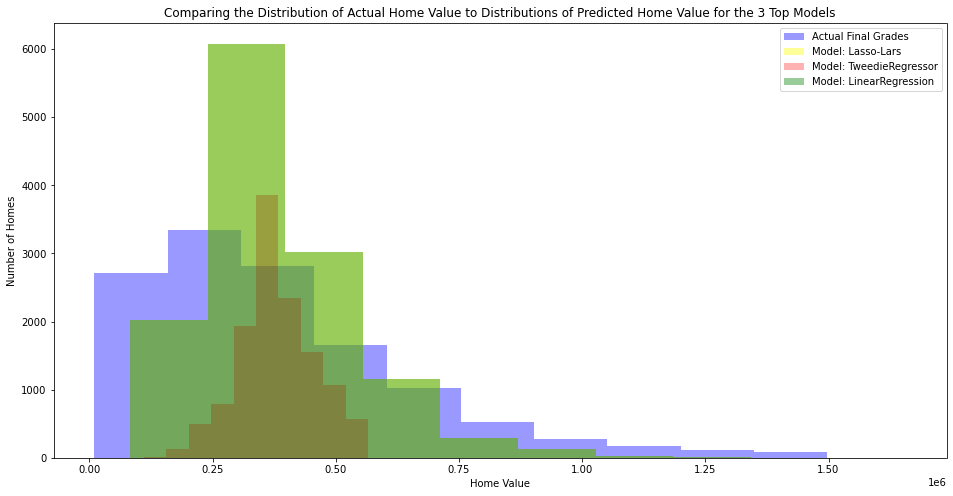

In [127]:
# Plot visualizing Actual Home Value vs Predicted Home Value on 3 Best Models 
plt.figure(figsize=(16,8))
plt.hist(predictions.actual, color='blue', alpha=.4, label="Actual Final Grades")
plt.hist(predictions.lasso_lars_a_1, color='yellow', alpha=0.4, label="Model: Lasso-Lars")
plt.hist(predictions.glm_p_0, color='red', alpha=.3, label="Model: TweedieRegressor")
plt.hist(predictions.simple_lm, color='green', alpha=.4, label="Model: LinearRegression")
plt.xlabel("Home Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the 3 Top Models")
plt.legend()
plt.show()

# Modeling Evaluation

In [128]:
# Calculate mean squared error for every column in the train_predictions df
def calculate_mse(y_predicted):
    return mean_squared_error(train_predictions.actual, y_predicted)

print('Train baseline MSE: {}.'.format(train_rmse))
train_predictions.apply(calculate_mse).sort_values()

Train baseline MSE: 272118.84506691294.


actual             0.000000e+00
simple_lm          4.924443e+10
lasso_lars_a_05    4.924557e+10
lasso_lars_a_1     4.924898e+10
lasso_lars_a_2     4.926264e+10
glm_p_0            6.718535e+10
baseline           7.404867e+10
glm_p_1            7.404867e+10
dtype: float64

In [129]:
# Calculate mean squared error for every column in the predictions df
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

print('Validation baseline MSE: {}.'.format(validate_rmse))
predictions.apply(calculate_mse).sort_values()

Validation baseline MSE: 268096.9138598306.


actual             0.000000e+00
simple_lm          4.722775e+10
lasso_lars_a_05    4.723061e+10
lasso_lars_a_1     4.723583e+10
lasso_lars_a_2     4.725336e+10
glm_p_0            6.511204e+10
baseline           7.187596e+10
glm_p_1            7.187596e+10
dtype: float64

In [130]:
# Calculate root mean squared error (RMSE) for every column in the train_predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(train_predictions.actual, y_predicted))

print('Train baseline RMSE: {}.'.format(train_rmse))
train_predictions.apply(calculate_rmse).sort_values()

Train baseline RMSE: 272118.84506691294.


actual                  0.000000
simple_lm          221910.865863
lasso_lars_a_05    221913.429433
lasso_lars_a_1     221921.119966
lasso_lars_a_2     221951.879434
glm_p_0            259201.362112
baseline           272118.845067
glm_p_1            272118.845067
dtype: float64

In [131]:
# Calculate root mean squared error (RMSE) for every column in the predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions.actual, y_predicted))

print('Validation baseline RMSE: {}.'.format(validate_rmse))
predictions.apply(calculate_rmse).sort_values()

Validation baseline RMSE: 268096.9138598306.


actual                  0.000000
simple_lm          217319.455730
lasso_lars_a_05    217326.036415
lasso_lars_a_1     217338.051334
lasso_lars_a_2     217378.379862
glm_p_0            255170.615728
baseline           268096.913860
glm_p_1            268096.913860
dtype: float64

### Evaluate on Test: Best Model (Linear Regression, `simple_lm`)

In [132]:
test_predictions = pd.DataFrame({
    'actual': test['home_value'],
    'baseline': baseline
}) 

In [133]:
test_predictions.head()

,actual,baseline
21816,79477,377672.367962
29518,611458,377672.367962
49732,324879,377672.367962
41274,59652,377672.367962
47604,215371,377672.367962


In [134]:
test_predictions.shape

(10613, 2)

In [135]:
#Create an instance of the model and fit it to my data
lm = LinearRegression().fit(x_train_scaled, y_train_scaled)

test_predictions['simple_lm'] = lm.predict(x_test_scaled)

test_predictions.head()

,actual,baseline,simple_lm
21816,79477,377672.367962,399792.291476
29518,611458,377672.367962,611638.158403
49732,324879,377672.367962,215360.414827
41274,59652,377672.367962,278717.963066
47604,215371,377672.367962,395783.936060


In [136]:
# Calculate mean squared error for the test_predictions df
def calculate_mse(y_predicted):
    return mean_squared_error(test_predictions.actual, y_predicted)

print('Test baseline MSE: {}.'.format(test_rmse))
test_predictions.apply(calculate_mse).sort_values()

Test baseline MSE: 270460.22757535306.


actual       0.000000e+00
simple_lm    4.955666e+10
baseline     7.314873e+10
dtype: float64

In [137]:
# Calculate root mean squared error (RMSE) for the test_predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(test_predictions.actual, y_predicted))

print('Test baseline RMSE: {}.'.format(test_rmse))
test_predictions.apply(calculate_rmse).sort_values()

Test baseline RMSE: 270460.22757535306.


actual            0.000000
simple_lm    222613.258374
baseline     270460.227575
dtype: float64

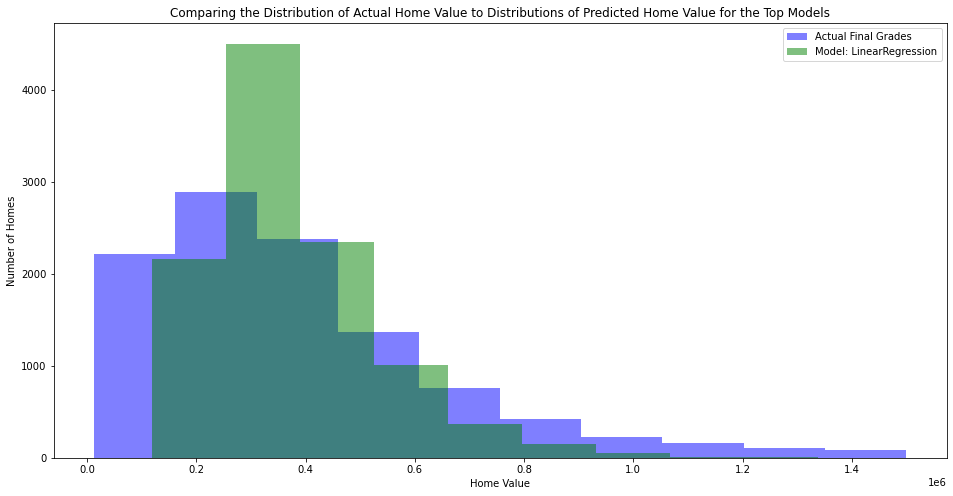

In [138]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(test_predictions.actual, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(test_predictions.simple_lm, color='green', alpha=.5, label="Model: LinearRegression")
plt.xlabel("Home Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the Top Models")
plt.legend()
plt.show()